## Analyze TriOS Data

Uncertainty, comparing to TSG, and 

In [101]:
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd

import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv("data/ivan_cruise/SW21009R_NRL/EventData/DataLogger/Data every 1 min_001.elg")
df.head()

Date      Time  SW-ZDA-Year  SW-ZDA-Month  SW-ZDA-Day  SW-ZDA-Time  \
0  08/25/2021  12:46:24         2021             8          25    124935.70   
1  08/25/2021  12:47:25         2021             8          25    125035.70   
2  08/25/2021  12:48:25         2021             8          25    125135.70   
3  08/25/2021  12:49:25         2021             8          25    125235.69   
4  08/25/2021  12:50:25         2021             8          25    125336.69   

   SW-GGA-Lat SW-GGA-NorS  SW-GGA-Long SW-GGA-EorW  ...  \
0   3433.3240           N    7610.8499           W  ...   
1   3433.4081           N    7610.6764           W  ...   
2   3433.4919           N    7610.5111           W  ...   
3   3433.5739           N    7610.3362           W  ...   
4   3433.6615           N    7610.1648           W  ...   

   SW-Weather-HumidRel-%  SW-Wind-WindSpeedRel  SW-Wind-WindAngleRel  \
0                   76.1                  5.00                 76.40   
1                   75.7                  4.49                 86.89   
2                   75.2                  3.29                 95.20   
3                   75.6                  5.29                 80.90   
4                   75.3                  2.90                 99.29   

   TrueWind-DRV-SPEED  TrueWind-DRV-DIRECTION  TSG--temp-SBE38  TSG--sal  \
0               10.75                  219.05          27.7042   35.6590   
1               12.15                  215.33          27.6905   35.6585   
2               11.20                  214.90          27.6949   35.6639   
3               12.10                  213.94          27.6968   35.6928   
4               11.44                  221.88          27.6971   35.6891   

   SW-Depth-DBT-Depth below transducer (m)  DepthOverall-DRV-VALUE  \
0                                    36.91                   37.88   
1                                    37.36                   38.36   
2                                    37.80                   38.80   
3                                    36.98                   37.98   
4                                    36.95                   37.95   

   Unnamed: 24  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [3]:
len(df)

6859

In [4]:
# about 5 days
len(df) / 60 / 24

4.763194444444444

The ship's computer was about 4 minutes behind so adding that here. Will fix this by using the data stamped by the GPS clock.

In [5]:
date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')

Convert their format into the lat and lon format that is easier to work with in geopandas and python

In [6]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

<AxesSubplot:>

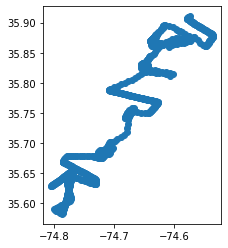

In [7]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.loc['2021-08-27 8:00:00':'2021-08-27 23:45:00'].plot()

In [8]:
df.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [9]:
cdom_files = [
    'data/ivan_cruise/cdom/cdom_flu_output_210825_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210826_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210827_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210828_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210829_1.txt'
             ]

cdom_dfs = []

for item in cdom_files:
    cdom_data = open(item)
    lines = cdom_data.readlines()
    sensor_values = []
    utc_times = []
    for i in range(len(lines)):
        line = lines[i]
        if "sensor" in line:
            try:
                line = line.split('= ')[1]
                line = line.replace('\n', '')
                sensor_values.append(int(line))
                if "UTC" in lines[i-1]:
                    data_time = lines[i-1][5:-2]
                    utc_times.append(data_time)
                elif "UTC" in lines[i+1]:
                    data_time = lines[i+1][5:-2]
                    utc_times.append(data_time)
            except:
                pass
    print(len(sensor_values)-len(utc_times))
    sensor_values = sensor_values[len(sensor_values)-len(utc_times):]
    utc_times = pd.to_datetime(utc_times)
    cdom_df = pd.DataFrame(np.array(sensor_values)/1024.0*5, columns = ['cdom_volts'])
    cdom_df['utc_dt'] = utc_times
    cdom_df  = cdom_df.set_index('utc_dt')
    cdom_dfs.append(cdom_df)
    
cdom_df = pd.DataFrame().append(cdom_dfs)

12
285
2
28
104


#### pull in the SST data from GOES

In [10]:
goes_ds = xr.open_dataset('data/jplStarG16SSTv270_8997_d932_2101.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


#### Pull in the TriOS radiometer data

In [11]:
trios_fns = [
    'data/ivan_cruise/trios/shearwater_trios_20210826.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210827.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210828.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210829.csv',
            ]
trios_dfs = []
for fn in trios_fns:
    trios_dfs.append(pd.read_csv(fn))

trios_df = pd.DataFrame().append(trios_dfs)

Based on our notes I believe that the TriOS data was saved as local time so I convert it here to UTC. I have not included the offset compared to the inline but that is likely about 10 seconds or more.

In [12]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['utc_dt'] =trios_df['datetime'] + timedelta(hours=4) # moving it to UTC
trios_df = trios_df.set_index('utc_dt')

<AxesSubplot:xlabel='utc_dt'>

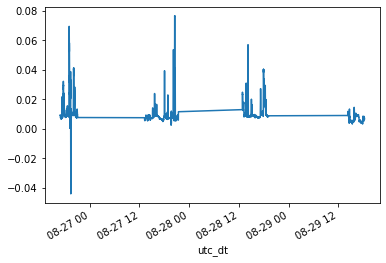

In [13]:
trios_df['400'].rolling(window=6*3).mean().plot()

In [14]:
# these are the coefficients based on the Hu et al 2012 paper

ci1 = -0.49
ci2 = 191.6590

# these are some coefficients that I calculated using the same exact method but trying to optimize for the Micasense bands

# ci1 = -0.38152295986028695
# ci2 = 271.37634868

# average of 443*.5 + 489*1.5
# ci1 = -0.30002281538304754
# ci2 = 310.5772338

# ci1 = -0.21380600002416383
# ci2 = 572.01573044



def oc_index(blue, green, red):
    blue, green, red = blue, green, red
    CI = green - ( blue + (555 - 477)/(667 - 477) * (red - blue) )
    ChlCI = 10**(ci1 + ci2*CI)
    return(ChlCI)

In [15]:
trios_df['chla_oci'] = oc_index(trios_df.iloc[:, 156:161].mean(axis=1).values, trios_df.iloc[:, 232:240].mean(axis=1).values, trios_df.iloc[:, 346:351].mean(axis=1).values)

Some of the values are way too high so cutting those off.

In [16]:
trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan

<ipython-input-16-07c79c7d9104>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan


(0.0, 0.4)

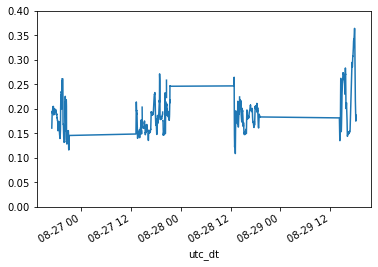

In [17]:
fig, ax = plt.subplots()
trios_df['chla_oci'].rolling(window=6*5).mean().plot(ax=ax)
ax.set_ylim(0,.4)

#### Filter all TriOS data for outliers and make dataset that is just the transects

In [18]:
start_times = ['2021-08-26 12:15:00', '2021-08-27 11:38:00', '2021-08-27 16:09:00', '2021-08-27 18:30:00', '2021-08-27 22:25:00', '2021-08-28 10:50:00',
               '2021-08-28 13:48:00', '2021-08-28 15:08:00', '2021-08-28 18:31:00', '2021-08-28 20:16:00', '2021-08-29 11:10:00', '2021-08-29 14:39:00',
               '2021-08-29 16:15:00']


end_times   = ['2021-08-26 14:12:00', '2021-08-27 12:52:00', '2021-08-27 17:40:00', '2021-08-27 18:45:00', '2021-08-27 23:35:00', '2021-08-28 12:05:00',
               '2021-08-28 14:05:00', '2021-08-28 16:48:00', '2021-08-28 18:56:00', '2021-08-28 21:50:00', '2021-08-29 13:40:00', '2021-08-29 15:00:00',
               '2021-08-29 17:52:00']

In [19]:
trios_transects = []
timestamps = []

for i in range(13):
    if trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*3).mean()['chla_oci'].empty:
        pass
    else:
        print(i)
        
        trios_df_transect = trios_df.loc[start_times[i]:end_times[i]]
        
        # Calculate rolling median and filter everything based on 440nm
        rolling_440 = trios_df_transect['440'].rolling(window=6*2).median()
        upper_threshold = 0.0005
        lower_threshold = -0.0005
        # filter based on threshold all in one line 
        df_filtered = trios_df_transect.drop(trios_df_transect[(trios_df_transect['440']-rolling_440>upper_threshold)|(trios_df_transect['440']- rolling_440<lower_threshold)].index) 

        trios_transects.append(df_filtered)
        timestamps.append(df_filtered['TimeStamp'])
        
trios_transects = pd.concat(trios_transects)

2
3
6
7
8
11
12


In [20]:
timestamps = [item for sublist in timestamps for item in sublist]

In [21]:
# subtract NIR from whole spectrum
corrected_specs = []
for i in range(len(trios_transects)):
    corrected_specs.append(trios_transects.iloc[i,1:-2] - trios_transects.iloc[i,450:480].mean())

corrected_specs = pd.DataFrame(corrected_specs, columns=df_filtered.columns[1:-2] )
corrected_specs['chla_oci'] = oc_index(corrected_specs.iloc[:, 156:161].mean(axis=1).values, corrected_specs.iloc[:, 232:240].mean(axis=1).values, corrected_specs.iloc[:, 346:351].mean(axis=1).values)
corrected_specs['TimeStamp'] = timestamps

lats = []
lons = []
sals = []
temps = []
for i in range(len(corrected_specs)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(corrected_specs.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    sals.append(row['TSG--sal'])
    temps.append(row['TSG--temp-SBE38'])
corrected_specs['lat'] = lats
corrected_specs['lon'] = lons
corrected_specs['sal'] = sals
corrected_specs['temp'] = temps

trios_gdf = gpd.GeoDataFrame(corrected_specs, geometry=gpd.points_from_xy(corrected_specs.lon, corrected_specs.lat))
        

In [22]:
corrected_specs.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

### Pull in HPLC timings

In [23]:
hplc_df = pd.read_csv('data/ivan_cruise/hplc_timing.csv')

In [24]:
hplc_df.head()

Sample  Date  Time (LST)  Volume (ml)                               Notes
0       1  26-8        1605          500          at the start of Ivan's dye
1       2  26-8        1605          500          at the start of Ivan's dye
2       3  26-8        1632          500         in the middle of the front?
3       4  27-8         742          500  starting transect on offshore side
4       5  27-8         811          500             in front - T&S changing

In [25]:
hplc_df['datetime'] = pd.to_datetime([datetime.strptime(x, '%Y %d-%m %H%M') for x in '2021 ' + hplc_df.Date + ' ' + hplc_df['Time (LST)'].astype(str)])
hplc_df['datetime']   = hplc_df['datetime'] + timedelta(hours=4) # moving it to UTC
hplc_df['utc_dt']   = hplc_df['datetime']
hplc_df = hplc_df.set_index('utc_dt')

In [26]:
start_times

['2021-08-26 12:15:00',
 '2021-08-27 11:38:00',
 '2021-08-27 16:09:00',
 '2021-08-27 18:30:00',
 '2021-08-27 22:25:00',
 '2021-08-28 10:50:00',
 '2021-08-28 13:48:00',
 '2021-08-28 15:08:00',
 '2021-08-28 18:31:00',
 '2021-08-28 20:16:00',
 '2021-08-29 11:10:00',
 '2021-08-29 14:39:00',
 '2021-08-29 16:15:00']

In [27]:
goes_ds.sea_surface_temperature[:,:, :].hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc[start_times[i]:end_times[i]].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

IndexError: list index out of range

## Visualizing the subset of transects with potentially good radiometer data

In [28]:
plt.rcParams.update({'font.size': 14})

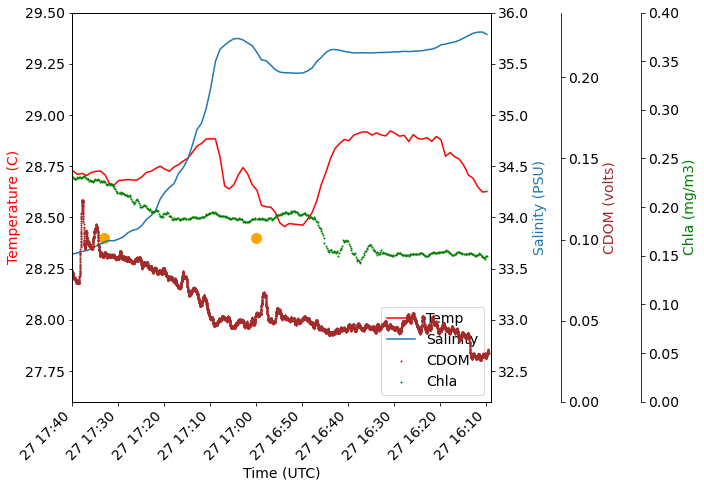

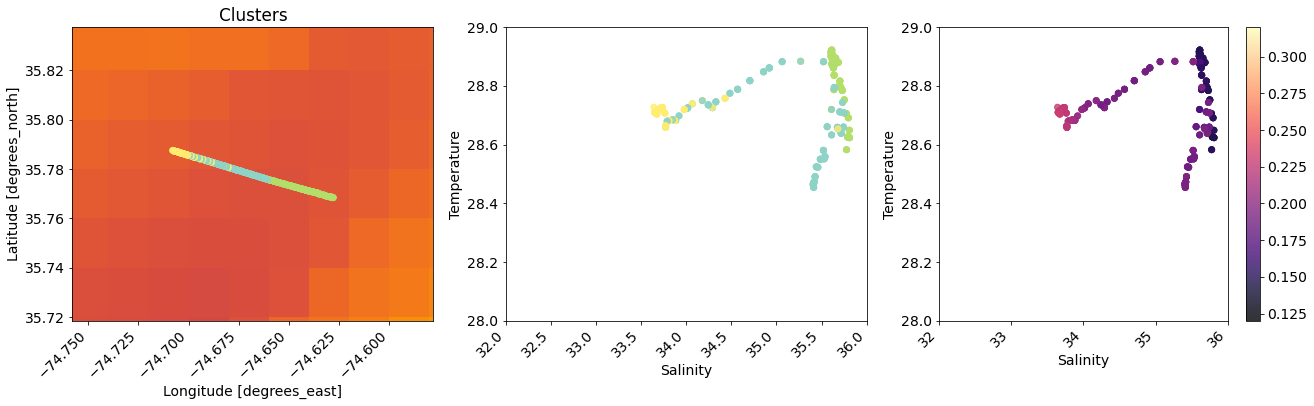

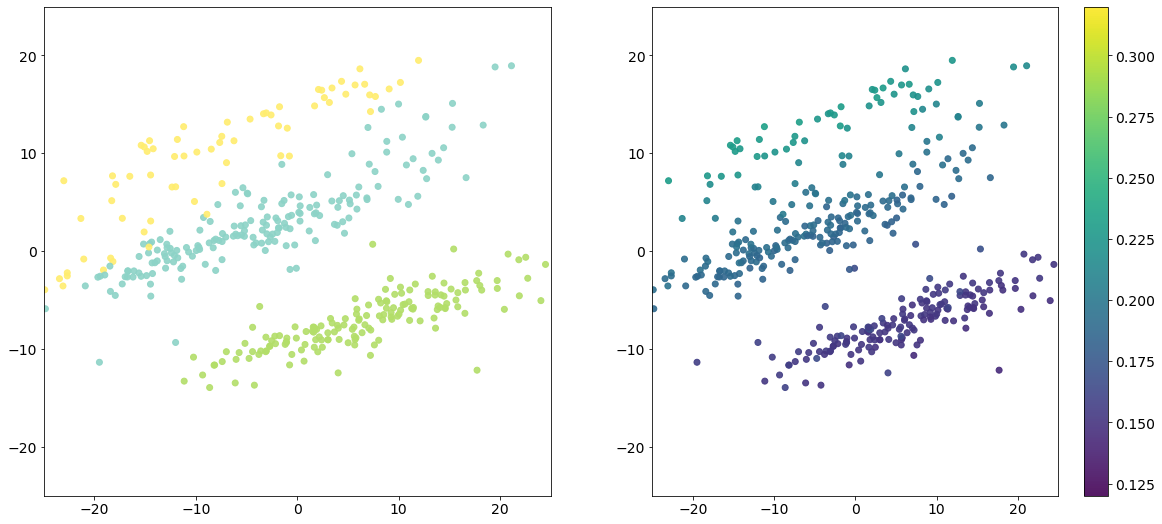

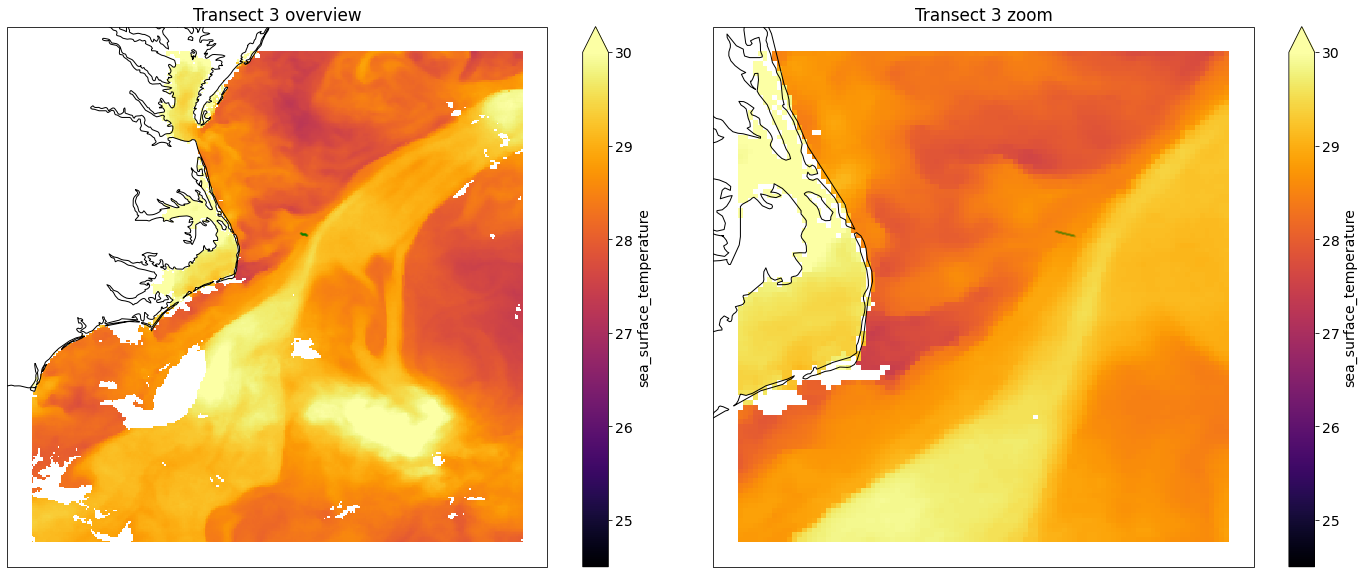

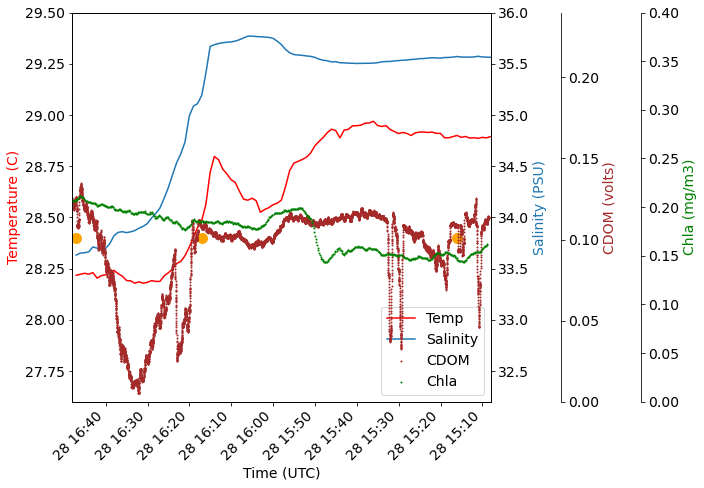

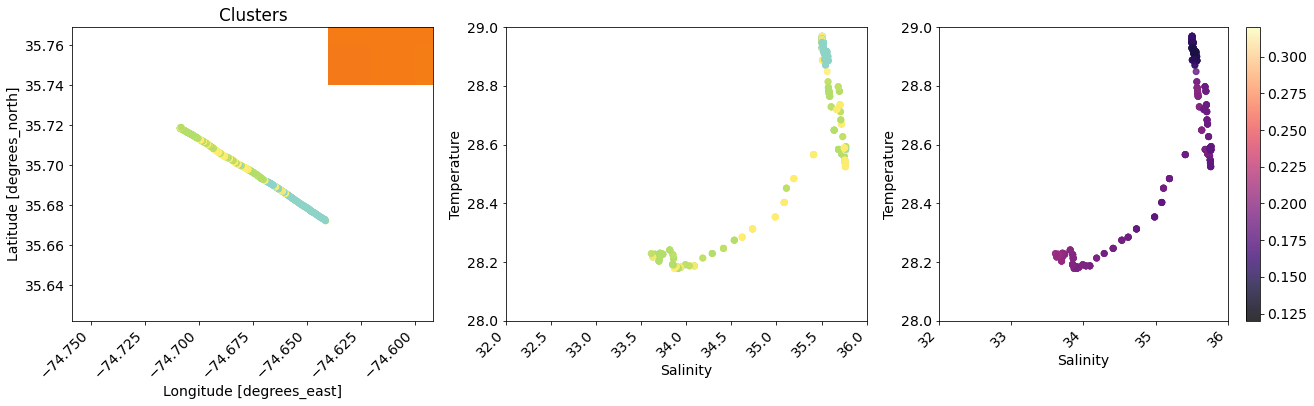

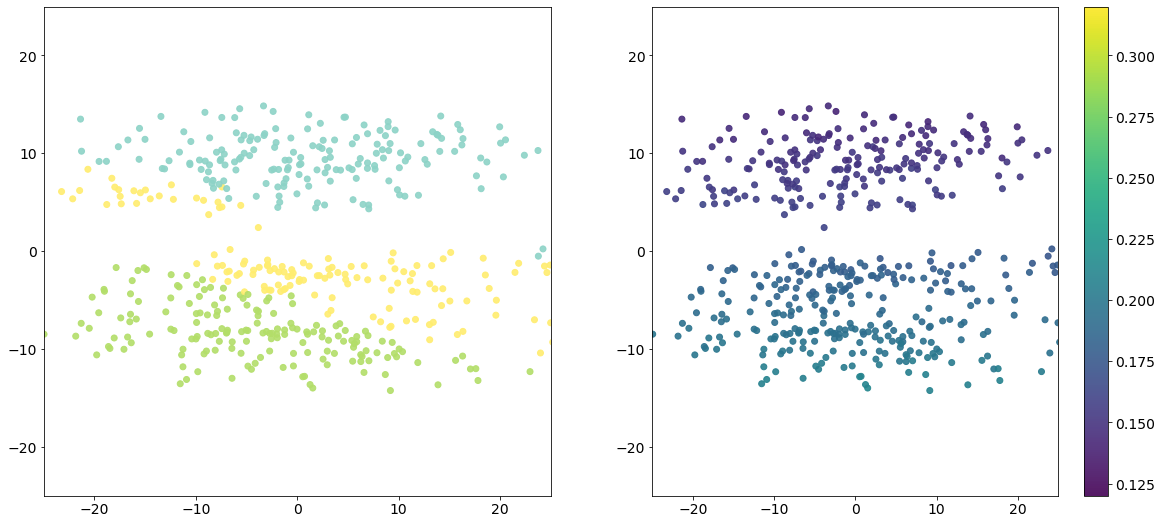

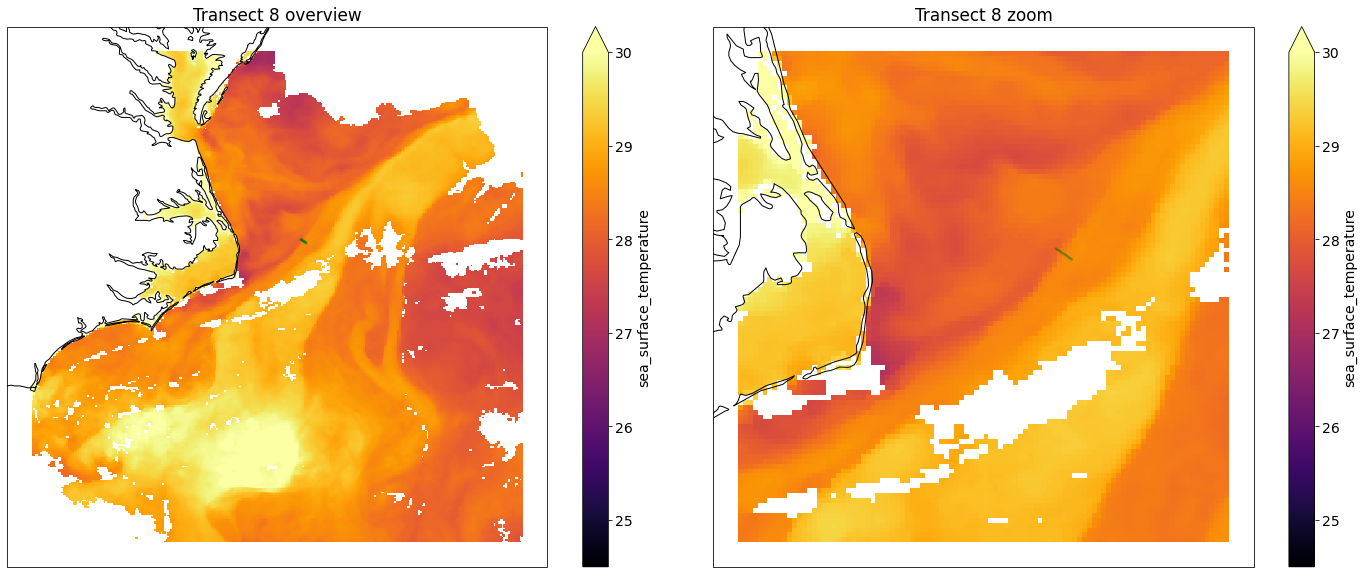

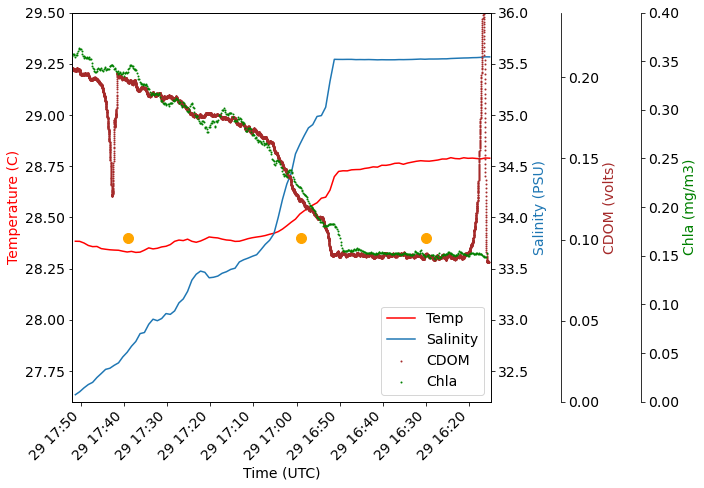

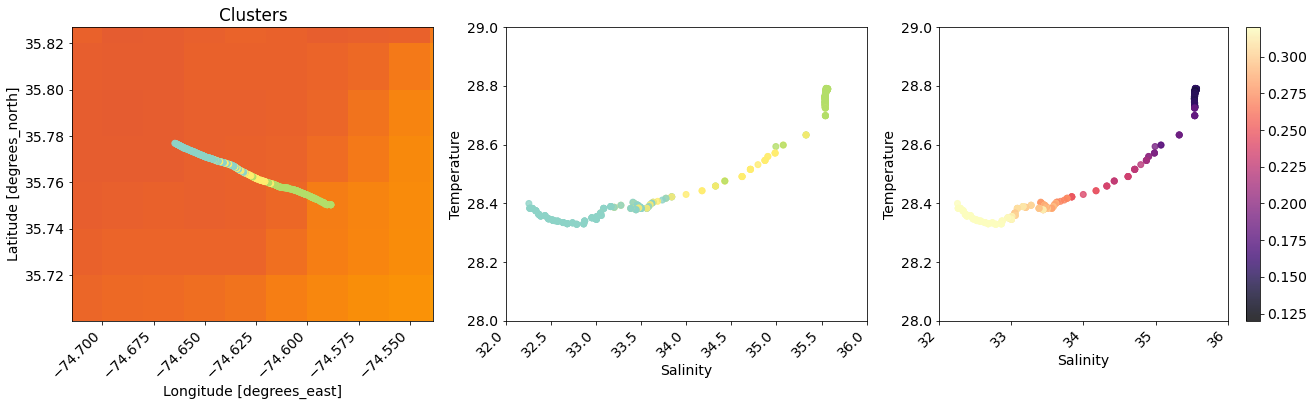

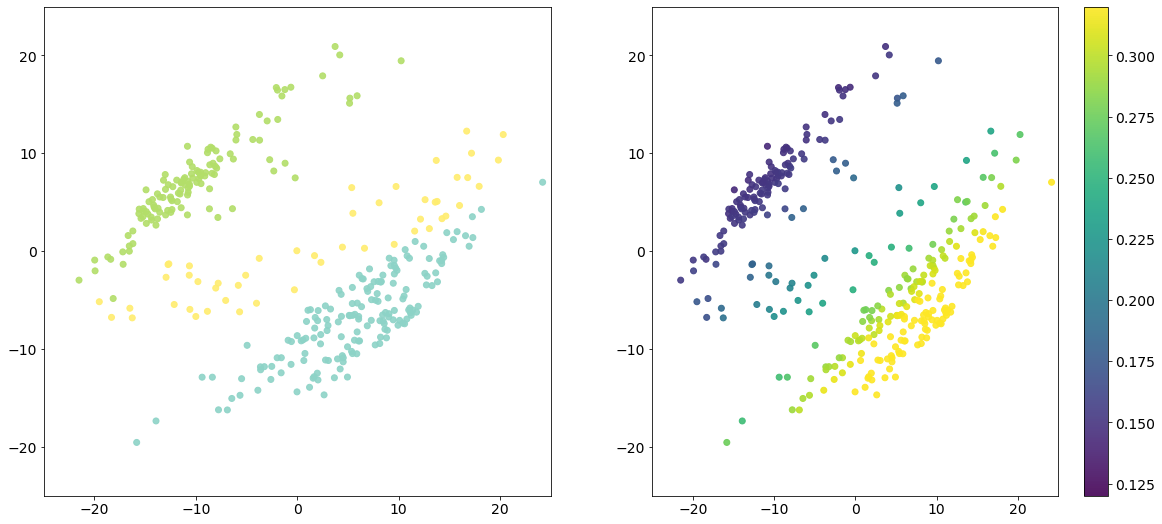

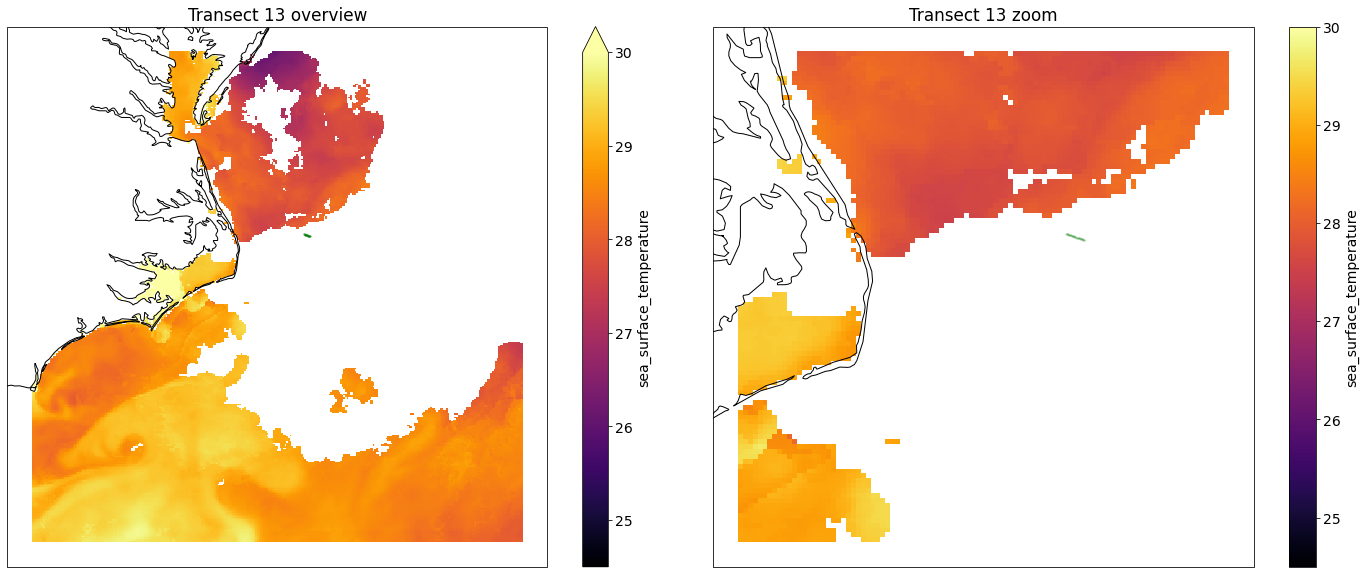

In [102]:
hours = [0,0,0,1,0,0,0,0,0,0,4,4,4]

titles = ['Transect 1', 'Transect 2', 'Transect 3', 'Transect 4', 
        'Transect 5', 'Transect 6', 'Transect 7', 'Transect 8',
        'Transect 9', 'Transect 10', 'Transect 11', 'Transect 12', 'Transect 13']

for i in range(13):
    if trios_df.loc[start_times[i]:end_times[i]]['chla_oci'].empty:
        pass
    elif hplc_df.loc[start_times[i]:end_times[i]]['datetime'].empty:
        pass
    else:
        # time series plot
        fig, ax = plt.subplots(figsize=(10,7))
        
        ax.set_xlim(pd.to_datetime(end_times[i]),pd.to_datetime(start_times[i]))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()

        ax.set_ylim(27.6, 29.5)
        ax1.set_ylim(32.2, 36)
        ax2.set_ylim(.0, .24)
        ax3.set_ylim(.0, .40)

        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax3.set_ylabel("Chla (mg/m3)")

        color1 = plt.cm.viridis(0)
        color2 = plt.cm.viridis(0.5)
        color3 = plt.cm.viridis(.9)

        p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], color='red', label='Temp')
        p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--sal'], label='Salinity')
                
        if hplc_df.loc[start_times[i]:end_times[i]]['datetime'].empty:
            hplc_data_x = None
            hplc_data_y = None
        else:
            hplc_data_x = hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)].index, 
            hplc_data_y = [28.4]*len(hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)])
#             print(hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)].Sample)
        ax.scatter(hplc_data_x, hplc_data_y, color='orange', label='HPLC', s=100)
        
        if cdom_df.loc[start_times[i]:end_times[i]].rolling(window=6*10).mean()['cdom_volts'].empty:
            cdom_data_x = None
            cdom_data_y = None
        else:
            cdom_data_x = cdom_df.loc[start_times[i]:end_times[i]].index, 
            cdom_data_y = cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean()['cdom_volts']
        p3  = ax2.scatter(cdom_data_x, cdom_data_y, color='brown', label='CDOM', s=1)
        
        trios_data_x = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean().index
        trios_data_y = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean()['chla_oci']
        p4  = ax3.scatter(trios_data_x, trios_data_y, color='green', label='Chla', s=1)

#         ax.set_title(titles[i])


    #     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
    #     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
    #     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

        lns = [p1, p2, p3, p4]
        ax.legend(handles=lns, loc='lower right')

        # right, left, top, bottom
        ax2.spines['right'].set_position(('outward', 70))

        ax3.spines['right'].set_position(('outward', 150))

        # no x-ticks                 
    #     ax2.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
        ax3.yaxis.label.set_color('green')

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/'+titles[i] +'.png')
    #     plt.close()
        plt.show()
        
        # cluster and T-S diagram
        
        trios_subset = trios_gdf.loc[start_times[i]:end_times[i]]
        # cutting off the parts most influenced by chla absorption
        kmeans = KMeans(n_clusters=3, random_state=0).fit(trios_subset.values[:,120:-315])
        
        fig, ax = plt.subplots(1,3, figsize=(22,6))
#         trios_subset.plot(ax=ax[0])
        
        trios_data_x = trios_subset.lon
        trios_data_y = trios_subset.lat
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=14), pd.to_datetime(end_times[i])-timedelta(hours=14))).sea_surface_temperature.mean(dim='time').plot(ax=ax[0], vmin=26.5, vmax=29.5, cmap='inferno', add_colorbar=False)

        ax[0].scatter(trios_data_x, trios_data_y, cmap='Set3', c=kmeans.labels_, label='cluster')
        
        
        ax[0].set_xlim(trios_data_x.min()-0.05, trios_data_x.max()+0.05)
        ax[0].set_ylim(trios_data_y.min()-0.05,trios_data_y.max()+0.05)

        # ss = ax.scatter(trios_gdf.lon, trios_gdf.lat, c=trios_gdf.chl, s=100)
        # fig.colorbar(sc,ax=ax)
        # fig.colorbar(sc, ax=ax)
        fig.autofmt_xdate(rotation=45)
        ax[0].set_title('Clusters')
        # fig.savefig('trios_radiometers_chlaci.png')
        
        ax[1].scatter(trios_subset['sal'], trios_subset['temp'], alpha=0.8, c=kmeans.labels_, cmap='Set3')
        ax[1].set_xlim(32,36)
        ax[1].set_ylim(28,29)

        ax[1].set_xlabel("Salinity")
        ax[1].set_ylabel("Temperature")
        
        sc = ax[2].scatter(trios_subset['sal'], trios_subset['temp'], alpha=0.8, c=trios_subset['chla_oci'], vmin=.12,vmax=.32, cmap='magma', label='chla')
        ax[2].set_xlim(32,36)
        ax[2].set_ylim(28,29)
        
        ax[2].set_xlabel("Salinity")
        ax[2].set_ylabel("Temperature")


        fig.colorbar(sc)
#         fig.savefig('aug_clusters_t_s_trios'+titles[i]+'.png')
        plt.show()
        
        x = trios_subset.values[:,120:-315]
#         x = x[12:,:]
        # Standardizing the features
        x = StandardScaler().fit_transform(x)
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(x)

        fig, ax = plt.subplots(1,2, figsize=(20,9))
        sc = ax[1].scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_subset['chla_oci'], vmin=.12,vmax=.32, cmap='viridis', label='chla')
        fig.colorbar(sc)
        ax[1].set_ylim(-25,25)
        ax[1].set_xlim(-25,25)
        ax[0].scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_, cmap='Set3')
        ax[0].set_ylim(-25,25)
        ax[0].set_xlim(-25,25)
        
#         fig.savefig('aug_pca_t_s_trios'+titles[i]+'.png')
        
        plt.show()
        # ax.set_ylim(-3,2)
        # ax.set_xlim(-6,8)
        # fig.savefig('pca_transect.png')



        # SST image

        fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
        ax[0].coastlines(resolution='10m')
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green', alpha=.05)

        ax[1].coastlines(resolution='10m')
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,75:175, 100:200].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.05)
        # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
        ax[0].set_title(titles[i] + ' overview')
        ax[1].set_title(titles[i] + ' zoom')
        fig.tight_layout()
    #     fig.savefig('figs/'+titles[i] +'sat_overview.png')
    #     plt.close()
        plt.show()    

        # fig.savefig('transect' + str(i) '_s_t.png')

## Quantify uncertainty in the trios instrument on the SW

In this section I try to quantify uncertainty in the method by using a period where we didn't move much and then propogate that error to the chla measurement.

In [45]:
static_trios_df = trios_df.loc['2021-08-26 19:46:00':'2021-08-26 19:55:00']
len(static_trios_df)

55

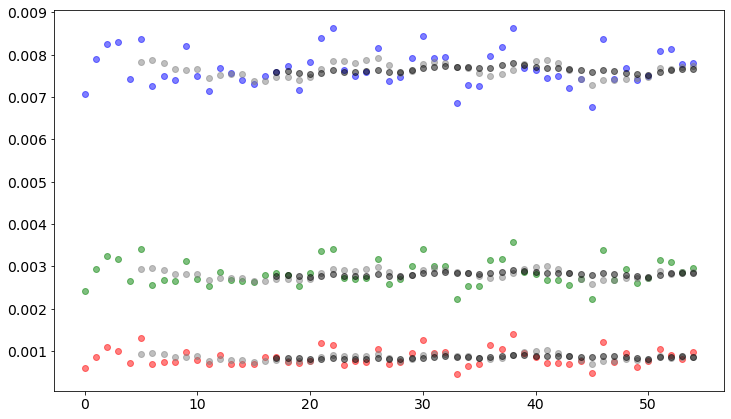

In [46]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:#,[232,240,'green'],[346,351,'red']]:
#     band_mean = static_trios_df.iloc[:, l:u].mean().mean()
#     band_std = static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1).std()
    
#     ax.axhline(band_mean,color=c)
#     ax.axhline(band_mean+band_std,color=c, ls='--')
#     ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=0.5)
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='grey', alpha=0.5)
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=0.5)
    
# ax.set_ylim(-0.001,0.004)
plt.show()

Text(0.5, 0, 'Repeated measurement count')

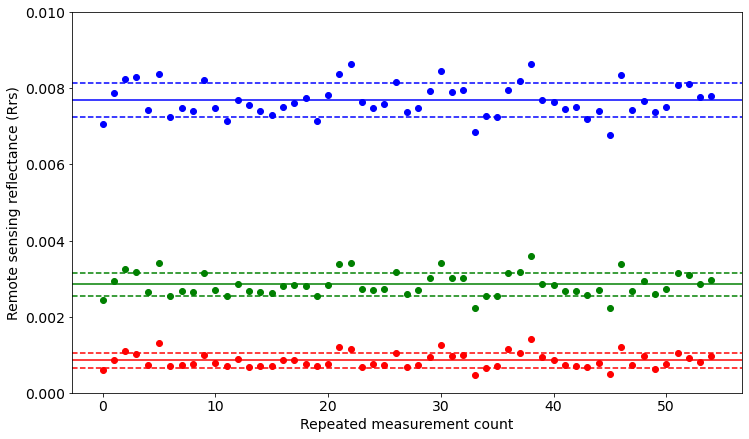

In [47]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    band_std = static_trios_df.iloc[:, l:u].mean(axis=1).std()
    
    
    ax.axhline(band_mean,color=c)
    ax.axhline(band_mean+band_std,color=c, ls='--')
    ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1)

ax.set_ylim(0,0.01)

ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
# fig.savefig('repeated_measurements_trios.png',dpi=300)

Text(0.5, 0, 'Repeated measurement count')

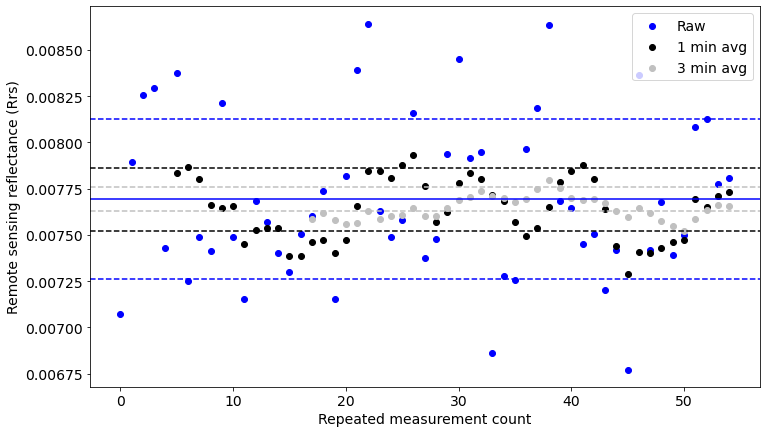

In [48]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    ax.axhline(band_mean,color=c)
    
    for i,c_std in [[1,'blue'],[6,'black'],[6*3,'silver']]:
        band_std = static_trios_df.rolling(window=i).mean().iloc[:, l:u].mean(axis=1).std()
        ax.axhline(band_mean+band_std,color=c_std, ls='--')
        ax.axhline(band_mean-band_std,color=c_std, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1, label='Raw')
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1, label='1 min avg')
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1, label='3 min avg')
ax.legend(loc='upper right')    
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
# fig.savefig('repeated_measurements_blue_avg.png',dpi=300)

You need the uncertainties package for this.

In [52]:
pip install --upgrade uncertainties

     |████████████████████████████████| 98 kB 298 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [53]:
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

In [54]:
blue_u = ufloat(static_trios_df.iloc[:, 156:161].mean().mean(), np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values))
green_u = ufloat(static_trios_df.iloc[:, 232:240].mean().mean(), np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values))
red_u = ufloat(static_trios_df.iloc[:, 346:351].mean().mean(), np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values))
blue_u, green_u, red_u

(0.007692916094545454+/-0.0004316484016933594,
 0.002850563672727273+/-0.0003025047880319788,
 0.000854057709090909+/-0.00020191965759646383)

In [55]:
blue_u = ufloat(static_trios_df.iloc[:, 156:161].mean().mean(), np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values))
green_u = ufloat(static_trios_df.iloc[:, 232:240].mean().mean(), np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values))
red_u = ufloat(static_trios_df.iloc[:, 346:351].mean().mean(), np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values))
blue_u, green_u, red_u

(0.007692916094545454+/-0.0004316484016933594,
 0.002850563672727273+/-0.0003025047880319788,
 0.000854057709090909+/-0.00020191965759646383)

Uncertainty based on the group of wavelengths used to calculate chla.

In [56]:
blue_uncert = np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values)
green_uncert = np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values)
red_uncert = np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values)
blue_uncert, green_uncert, red_uncert

(0.0004316484016933594, 0.0003025047880319788, 0.00020191965759646383)

Uncertainty based on a rolling window average of 6 measurements (1 minute)

In [57]:
blue_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 156:161].mean(axis=1).values)
green_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 232:240].mean(axis=1).values)
red_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 346:351].mean(axis=1).values)
blue_uncert, green_uncert, red_uncert

(0.00016776638783025022, 0.00010788283891465276, 7.161309946806462e-05)

In [58]:
chla_uncerts = []

for i in range(len(trios_df)):
    blue_u = ufloat(trios_df.iloc[i, 156:161].mean(), blue_uncert)
    green_u = ufloat(trios_df.iloc[i, 232:240].mean(), green_uncert) 
    red_u = ufloat(trios_df.iloc[i, 346:351].mean(), red_uncert)
    
    chla_u = oc_index(blue_u, green_u, red_u)
    
    chla_uncert = chla_u.s
    chla_uncerts.append(chla_uncert)

Example of calculating uncertainty

In [59]:
blue_u = ufloat(trios_df.iloc[i, 156:161].mean(), blue_uncert)
green_u = ufloat(trios_df.iloc[i, 232:240].mean(), green_uncert) 
red_u = ufloat(trios_df.iloc[i, 346:351].mean(), red_uncert)

chla_u = oc_index(blue_u, green_u, red_u)

In [60]:
trios_df.iloc[i, 156:161].mean(), blue_uncert

(0.0075986914000000004, 0.00016776638783025022)

In [ ]:
-260.43*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.000167

In [ ]:
(441.41*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.000107)

In [ ]:
(-180.98*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.0000716)

In [61]:
import math
math.sqrt(0.0068**2+0.0074**2+0.002**2)

0.010246950765959599

In [62]:
blue_u, green_u, red_u

(0.0075986914000000004+/-0.00016776638783025022,
 0.004682888499999999+/-0.00010788283891465276,
 0.0030533482+/-7.161309946806462e-05)

In [63]:
chla_u.error_components()

{0.0075986914000000004+/-0.00016776638783025022: 0.008886011061013754,
 0.0030533482+/-7.161309946806462e-05: 0.0026416236638908608,
 0.004682888499999999+/-0.00010788283891465276: 0.009693705918274897}

In [64]:
chla_u

0.20360693550654468+/-0.013412952791540152

In [65]:
chla_u

0.20360693550654468+/-0.013412952791540152

In [96]:
trios_df['chla_uncert'] = chla_uncerts

In [97]:
corrected_specs['chla_uncert'] = chla_uncerts

ValueError: Length of values (8145) does not match length of index (1556)

<ipython-input-67-779b19d7db1a>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
<ipython-input-67-779b19d7db1a>:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
<ipython-input-67-779b19d7db1a>:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')


Text(0.5, 0, 'Wavelength (nm)')

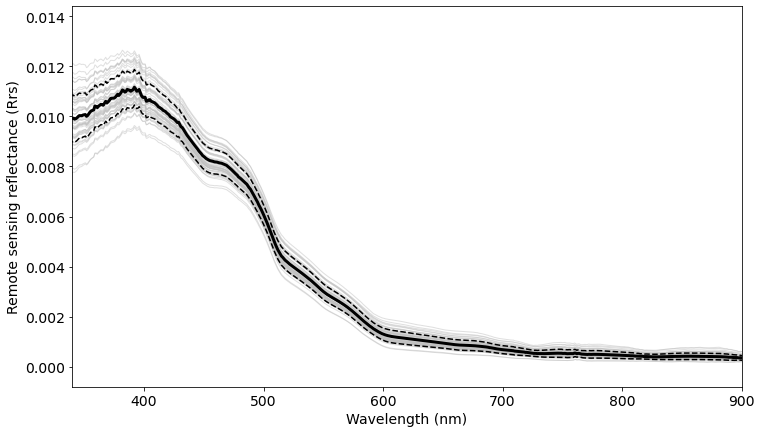

In [67]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2].values.T, color='silver', lw=1, alpha=0.5)
# ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2]+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
# ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2]-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('spectrum_repeated.png',dpi=300)

(340.0, 900.0)

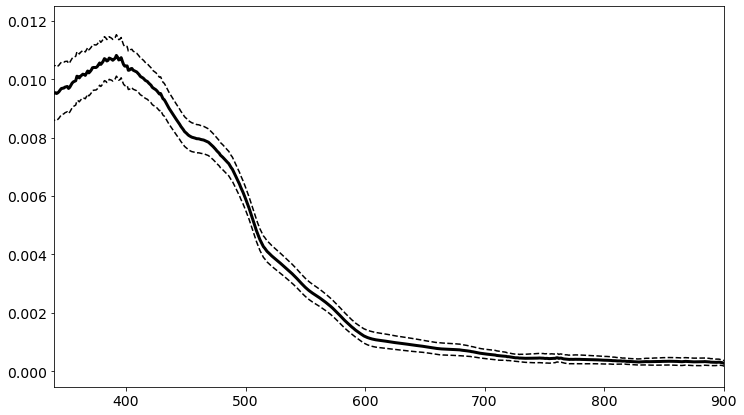

In [68]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2], color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2]+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2]-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)


<ipython-input-69-f8aafffdfa3d>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
<ipython-input-69-f8aafffdfa3d>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
<ipython-input-69-f8aafffdfa3d>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')


(340.0, 900.0)

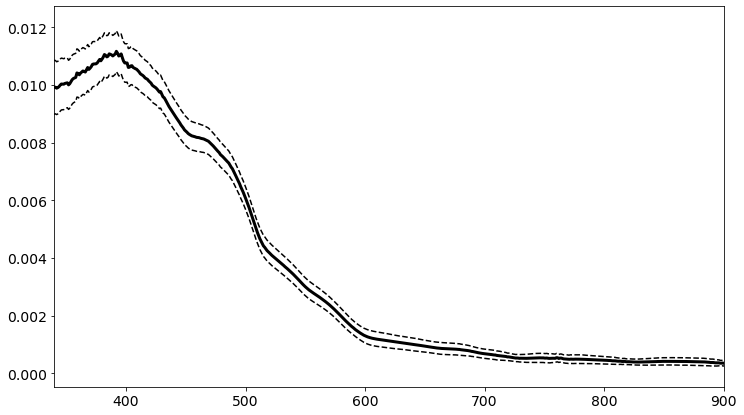

In [69]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)


### Now look at this on a specific transect

In [93]:
transect = 2
df_transect = df.loc[start_times[transect]:end_times[transect]]
trios_df_transect = corrected_specs.loc[start_times[transect]:end_times[transect]]
cdom_df_transect = cdom_df.loc[start_times[transect]:end_times[transect]]

In [71]:
static_trios_df.columns[1:-2].astype(int)

Int64Index([320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
            ...
            941, 942, 943, 944, 945, 946, 947, 948, 949, 950],
           dtype='int64', length=631)

In [72]:
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-7]

320    0.006882
321    0.006687
322    0.006593
323    0.006510
324    0.006456
         ...   
944   -0.000026
945   -0.000037
946   -0.000092
947   -0.000100
948   -0.000065
Length: 629, dtype: float64

Text(0.5, 1.0, '')

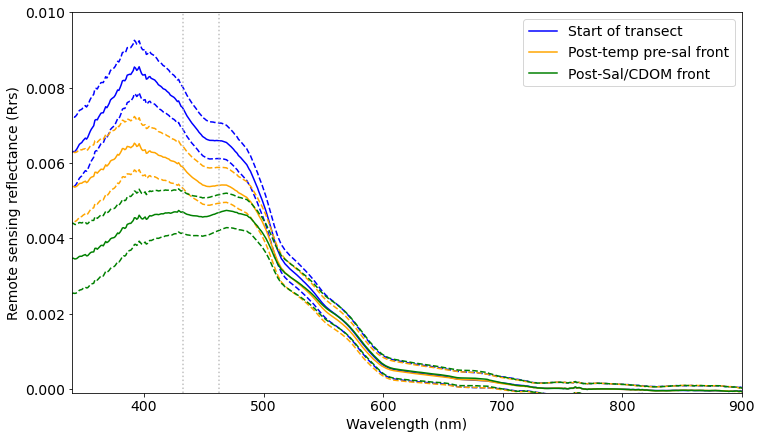

In [73]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-4].astype(int),trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-7],label='Start of transect', color='blue',)
ax.plot(static_trios_df.columns[1:-4].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-7]+static_trios_df.iloc[:, :-7].std(), color='blue', ls='--')
ax.plot(static_trios_df.columns[1:-4].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-7]-static_trios_df.iloc[:, :-7].std(), color='blue', ls='--')


# trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
# trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')


# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp pre-sal front')
ax.plot(static_trios_df.columns[1:-4].astype(int),trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-7],label='Post-temp pre-sal front', color='orange',)
ax.plot(static_trios_df.columns[1:-4].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-7]+static_trios_df.iloc[:, :-7].std(), color='orange', ls='--')
ax.plot(static_trios_df.columns[1:-4].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-7]-static_trios_df.iloc[:, :-7].std(), color='orange', ls='--')



ax.plot(static_trios_df.columns[1:-4].astype(int),trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-7],label='Post-Sal/CDOM front',  color='green', )
ax.plot(static_trios_df.columns[1:-4].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-7]+static_trios_df.iloc[:, :-7].std(), color='green', ls='--')
ax.plot(static_trios_df.columns[1:-4].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-7]-static_trios_df.iloc[:, :-7].std(), color='green', ls='--')


ax.axvline(443-10, color='silver', ls='dotted')
ax.axvline(443+20, color='silver', ls='dotted')

ax.legend()
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')

ax.set_xlim(340,900)
ax.set_ylim(-0.0001,0.01)

ax.set_title('')


# plt.savefig('radiometry_spectra_across_front.png',dpi=300)


(-0.0001, 0.01)

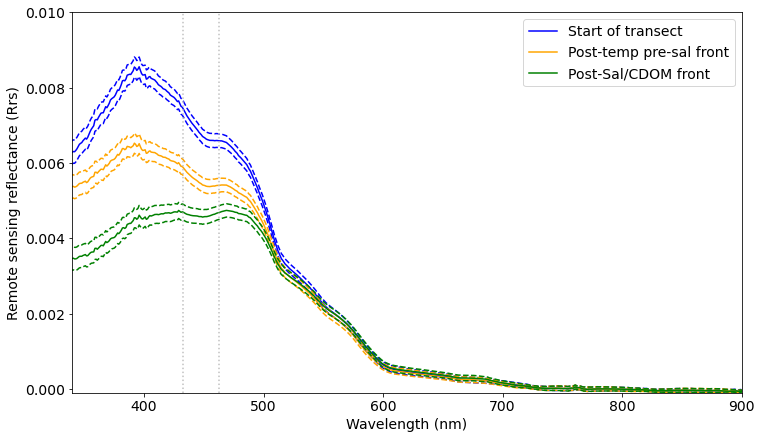

In [79]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-5],label='Start of transect', color='blue',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-5]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='blue', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-5]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='blue', ls='--')


# trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
# trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')

# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp pre-sal front')
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-5],label='Post-temp pre-sal front', color='orange',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-5]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='orange', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-5]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='orange', ls='--')



ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-5],label='Post-Sal/CDOM front',  color='green', )
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-5]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='green', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-5]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='green', ls='--')


ax.axvline(443-10, color='silver', ls='dotted')
ax.axvline(443+20, color='silver', ls='dotted')

ax.legend()
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')

ax.set_xlim(340,900)
ax.set_ylim(-0.0001,0.01)



# plt.savefig('radiometry_spectra_across_front_binned.png',dpi=300)


In [80]:
start_times[transect]

'2021-08-27 16:09:00'

In [81]:
end_times[transect]

'2021-08-27 17:40:00'

In [ ]:
plt.rcParams.update({'font.size': 16})

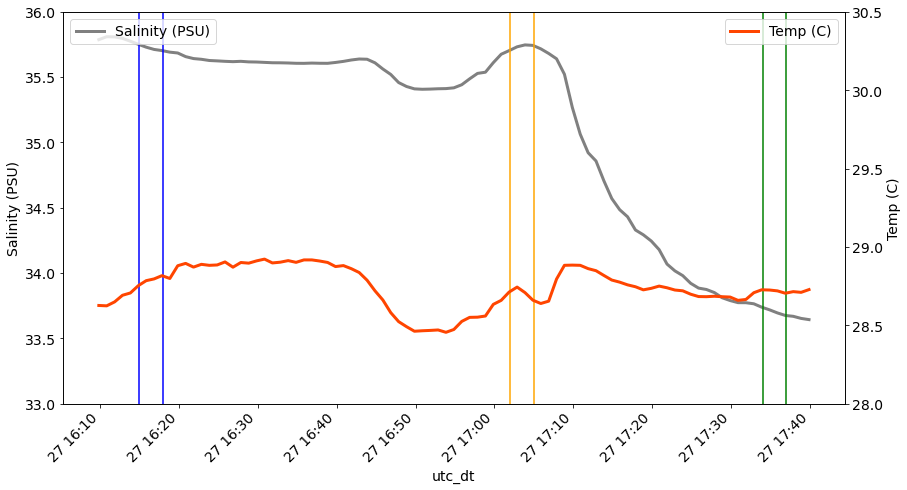

In [94]:
fig, ax = plt.subplots(figsize=(14,8))

df_transect.plot(y='TSG--sal',ax=ax, linewidth=3, color='grey', label='Salinity (PSU)')
ax.set_ylim(33,36)

ax1 = ax.twinx()
df_transect.plot(y='TSG--temp-SBE38',ax=ax1, linewidth=3, color='orangered', label='Temp (C)')
ax1.set_ylim(28,30.5)

ax.axvline('2021-08-27 16:15:00',color='blue')
ax.axvline('2021-08-27 16:18:00',color='blue')

ax.axvline('2021-08-27 17:02:00',color='orange')
ax.axvline('2021-08-27 17:05:00',color='orange')

ax.axvline('2021-08-27 17:34:00',color='green')
ax.axvline('2021-08-27 17:37:00',color='green')

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax.set_ylabel('Salinity (PSU)')
ax1.set_ylabel('Temp (C)')

# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('sal_temp_front.png')

KeyError: 'chla_uncert'

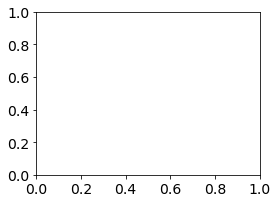

In [95]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(trios_df_transect['chla_uncert'])
ax.set_ylabel('Count')
ax.set_xlabel('Uncertainty (mg/m3)')
fig.tight_layout()
# fig.savefig('uncertanty_distribution.png',dpi=300)

In [ ]:
trios_df_transect['chla_oci']

The uncertainty is basically proportional to the chla

In [ ]:
np.unique(trios_df_transect['chla_uncert']/trios_df_transect['chla_oci'])

In [ ]:
trios_df_transect['chla_oci']

In [ ]:
trios_df_transect['chla_uncert']

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))

df_transect.plot(y='TSG--sal',ax=ax, linewidth=3, color='grey', label='Salinity (PSU)')
ax.set_ylim(33,36)

ax1 = ax.twinx()
df_transect.plot(y='TSG--temp-SBE38',ax=ax1, linewidth=3, color='orangered', label='Temp (C)')
ax1.set_ylim(28,30.5)

ax2 = ax.twinx()

trios_df_transect['chla_oci'].rolling(window=6).mean().plot(ax=ax2, color='green', label='Chla 1 min avg', linewidth=3)
(trios_df_transect['chla_oci'].rolling(window=6).mean()-trios_df_transect['chla_uncert']).plot(ax=ax2, color='green', label='', linewidth=2, ls='--')
(trios_df_transect['chla_oci'].rolling(window=6).mean()+trios_df_transect['chla_uncert']).plot(ax=ax2, color='green', label='', linewidth=2, ls='--')

# ax.axvline('2021-08-27 16:15:00',color='blue')
# ax.axvline('2021-08-27 16:18:00',color='blue')

# ax.axvline('2021-08-27 17:02:00',color='orange')
# ax.axvline('2021-08-27 17:05:00',color='orange')

# ax.axvline('2021-08-27 17:34:00',color='green')
# ax.axvline('2021-08-27 17:37:00',color='green')

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax.set_ylabel('Salinity (PSU)')
ax1.set_ylabel('Temp (C)')
ax2.set_ylabel('Chla (mg/m3)')

ax2.spines['right'].set_position(('outward', 90))

# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
# fig.savefig('chla_uncert_sal_temp.png')

In [ ]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

ax3.spines['right'].set_position(('outward', 80))
ax4.spines['right'].set_position(('outward', 160))


df_transect.plot(y='TSG--sal',ax=ax2, linewidth=3, color='grey')
ax2.set_ylim(33,36)

df_transect.plot(y='TSG--temp-SBE38',ax=ax3, linewidth=3, color='orange')
ax3.set_ylim(28,30.5)

trios_df_transect['chla_oci'].rolling(window=6).mean().plot(ax=ax, color='green', label='Chla 1min bin', linewidth=3)
(trios_df_transect['chla_oci'].rolling(window=6).mean()-trios_df_transect['chla_uncert']).plot(ax=ax, color='green', label='', linewidth=2, ls='--')
(trios_df_transect['chla_oci'].rolling(window=6).mean()+trios_df_transect['chla_uncert']).plot(ax=ax, color='green', label='', linewidth=2, ls='--')

ax.legend(loc='upper left')
ax.set_ylabel('chlorophyll-a mg/m3')
ax2.set_ylabel('salinity')
ax3.set_ylabel('temp (C)')
ax4.set_ylabel('cdom volts')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('chla_uncert_sal_temp.png')

### Explore the radiometer data a bit more

Checking out and clustering a transect

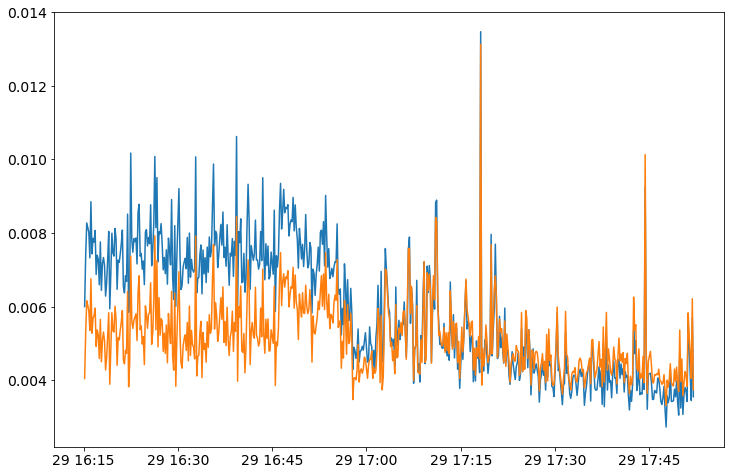

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(trios_df_transect['440'].rolling(window=1).mean())
ax.plot(trios_df_transect['500'].rolling(window=1).mean())

In [31]:
len(start_times)

13

### inspect a specific transect

In [99]:
transect = 12
df_transect = df.loc[start_times[transect]:end_times[transect]]
trios_df_transect = corrected_specs.loc[start_times[transect]:end_times[transect]]
cdom_df_transect = cdom_df.loc[start_times[transect]:end_times[transect]]

look at the data from this

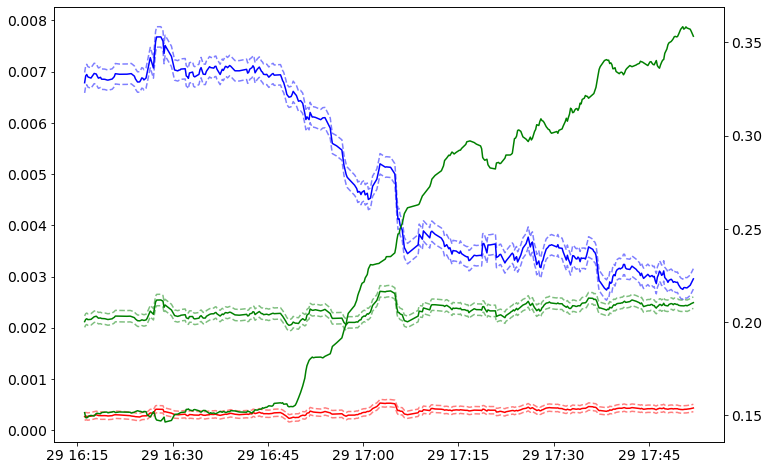

In [100]:
trios_df_transect

fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(trios_df_transect['440'].rolling(window=1).mean())
# ax.plot(trios_df_transect['460'].rolling(window=1).mean())
# ax.plot(trios_df_transect['440'].rolling(window=6*3).mean())
# ax.plot(df_filtered['440'])

window = 7
ax.plot(trios_df_transect['440'].rolling(window=window).mean(),c='blue')
ax.plot(trios_df_transect['440'].rolling(window=window).mean()+static_trios_df.rolling(6).mean()['440'].std(),c='blue',ls='--',alpha=0.5)
ax.plot(trios_df_transect['440'].rolling(window=window).mean()-static_trios_df.rolling(6).mean()['440'].std(),c='blue',ls='--',alpha=0.5)

ax.plot(trios_df_transect['550'].rolling(window=window).mean(),c='green')
ax.plot(trios_df_transect['550'].rolling(window=window).mean()+static_trios_df.rolling(6).mean()['550'].std(),c='green',ls='--',alpha=0.5)
ax.plot(trios_df_transect['550'].rolling(window=window).mean()-static_trios_df.rolling(6).mean()['550'].std(),c='green',ls='--',alpha=0.5)

ax.plot(trios_df_transect['660'].rolling(window=window).mean(),c='red')
ax.plot(trios_df_transect['660'].rolling(window=window).mean()+static_trios_df.rolling(6).mean()['660'].std(),c='red',ls='--',alpha=0.5)
ax.plot(trios_df_transect['660'].rolling(window=window).mean()-static_trios_df.rolling(6).mean()['660'].std(),c='red',ls='--',alpha=0.5)

ax2 = ax.twinx()

ax2.plot(trios_df_transect.chla_oci.rolling(window=window).mean(), c='green')



# ax.plot(trios_df_transect['440'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())
# ax.plot(trios_df_transect['550'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())

# ax.plot(df_filtered['520'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())


# ax.plot(df_filtered['660'].rolling(window=6*2).mean())

# ax.set_ylim(0.002,0.01)
# trios_df_transect.plot('440')

In [199]:
# Calculate rolling median
rolling_440 = trios_df_transect['440'].rolling(window=6*2).median()
upper_threshold = 0.0005
lower_threshold = -0.0005

# all in one line 
df_filtered = trios_df_transect.drop(trios_df_transect[(trios_df_transect['440']-rolling_440>upper_threshold)|(trios_df_transect['440']- rolling_440<lower_threshold)].index) 
# if you want to drop the column as well
# del df["rolling_temp"]

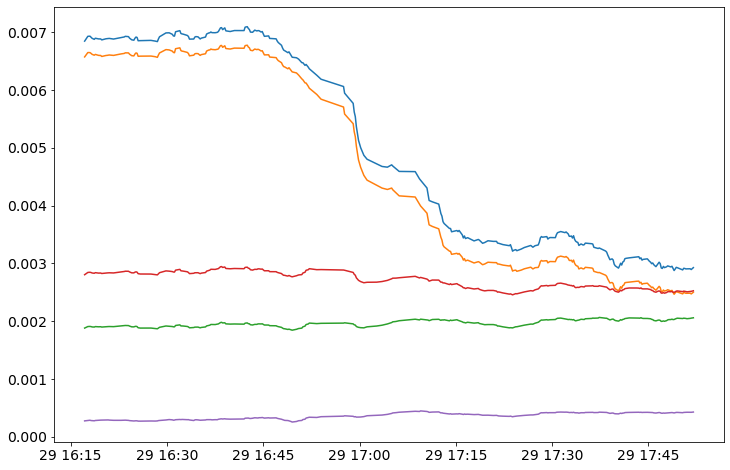

In [200]:
fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(trios_df_transect['440'].rolling(window=1).mean())
# ax.plot(trios_df_transect['460'].rolling(window=1).mean())
# ax.plot(trios_df_transect['440'].rolling(window=6*3).mean())
# ax.plot(df_filtered['440'])
ax.plot(df_filtered['440'].rolling(window=6*2).mean())
ax.plot(df_filtered['440'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())
ax.plot(df_filtered['550'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())

ax.plot(df_filtered['520'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())


ax.plot(df_filtered['660'].rolling(window=6*2).mean())

# ax.set_ylim(0.002,0.01)
# trios_df_transect.plot('440')

In [201]:
df_filtered.iloc[:,1:-2]

321       322       323       324       325  \
2021-08-29 16:15:10  0.005342  0.005383  0.005333  0.005271  0.005224   
2021-08-29 16:15:20  0.005442  0.005458  0.005385  0.005306  0.005246   
2021-08-29 16:15:30  0.005799  0.005783  0.005705  0.005626  0.005566   
2021-08-29 16:15:40  0.005119  0.005142  0.005082  0.005014  0.004962   
2021-08-29 16:15:50  0.005650  0.005663  0.005593  0.005512  0.005448   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.002661  0.002665  0.002617  0.002556  0.002509   
2021-08-29 17:51:00  0.002705  0.002704  0.002660  0.002607  0.002566   
2021-08-29 17:51:30  0.002004  0.002005  0.001965  0.001910  0.001868   
2021-08-29 17:51:40  0.001947  0.001940  0.001903  0.001852  0.001812   
2021-08-29 17:52:00  0.003927  0.003931  0.003873  0.003800  0.003741   

                          326       327       328       329       330  ...  \
2021-08-29 16:15:10  0.005256  0.005184  0.005047  0.005116  0.005195  ...   
2021-08-29 16:15:20  0.005269  0.005190  0.005048  0.005126  0.005227  ...   
2021-08-29 16:15:30  0.005592  0.005506  0.005350  0.005413  0.005506  ...   
2021-08-29 16:15:40  0.004985  0.004908  0.004768  0.004834  0.004930  ...   
2021-08-29 16:15:50  0.005473  0.005402  0.005266  0.005329  0.005418  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.002511  0.002439  0.002323  0.002358  0.002402  ...   
2021-08-29 17:51:00  0.002573  0.002503  0.002389  0.002424  0.002466  ...   
2021-08-29 17:51:30  0.001874  0.001801  0.001684  0.001718  0.001763  ...   
2021-08-29 17:51:40  0.001813  0.001745  0.001639  0.001675  0.001718  ...   
2021-08-29 17:52:00  0.003741  0.003657  0.003523  0.003552  0.003590  ...   

                          946       947       948       949       950  \
2021-08-29 16:15:10 -0.000235 -0.000450 -0.000701 -0.000786 -0.000749   
2021-08-29 16:15:20 -0.000403 -0.000530 -0.000644 -0.000569 -0.000461   
2021-08-29 16:15:30 -0.000726 -0.000702 -0.000719 -0.000709 -0.000649   
2021-08-29 16:15:40 -0.000626 -0.000626 -0.000623 -0.000551 -0.000451   
2021-08-29 16:15:50 -0.000690 -0.000659 -0.000629 -0.000651 -0.000712   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50 -0.000306 -0.000312 -0.000325 -0.000320 -0.000317   
2021-08-29 17:51:00 -0.000286 -0.000274 -0.000263 -0.000257 -0.000262   
2021-08-29 17:51:30 -0.000028 -0.000013 -0.000011 -0.000038 -0.000071   
2021-08-29 17:51:40 -0.000023  0.000010  0.000035 -0.000018 -0.000100   
2021-08-29 17:52:00 -0.000582 -0.000555 -0.000535 -0.000498 -0.000461   

                     chla_oci           TimeStamp        lat        lon  \
2021-08-29 16:15:10  0.168734  8/29/2021 12:15:10  35.750405 -74.588497   
2021-08-29 16:15:20  0.150625  8/29/2021 12:15:20  35.750405 -74.588497   
2021-08-29 16:15:30  0.149730  8/29/2021 12:15:30  35.750405 -74.588497   
2021-08-29 16:15:40  0.145817  8/29/2021 12:15:40  35.750405 -74.588497   
2021-08-29 16:15:50  0.148233  8/29/2021 12:15:50  35.750458 -74.590245   
...                       ...                 ...        ...        ...   
2021-08-29 17:50:50  0.354417  8/29/2021 13:50:50  35.776593 -74.663812   
2021-08-29 17:51:00  0.353535  8/29/2021 13:51:00  35.776593 -74.663812   
2021-08-29 17:51:30  0.358468  8/29/2021 13:51:30  35.776593 -74.663812   
2021-08-29 17:51:40  0.361546  8/29/2021 13:51:40  35.776593 -74.663812   
2021-08-29 17:52:00  0.340929  8/29/2021 13:52:00  35.776885 -74.664582   

                         sal  
2021-08-29 16:15:10  35.5670  
2021-08-29 16:15:20  35.5670  
2021-08-29 16:15:30  35.5670  
2021-08-29 16:15:40  35.5670  
2021-08-29 16:15:50  35.5676  
...                      ...  
2021-08-29 17:50:50  32.2684  
2021-08-29 17:51:00  32.2684  
2021-08-29 17:51:30  32.2684  
2021-08-29 17:51:40  32.2684  
2021-08-29 17:52:00  32.2578  

[273 rows x 635 columns]

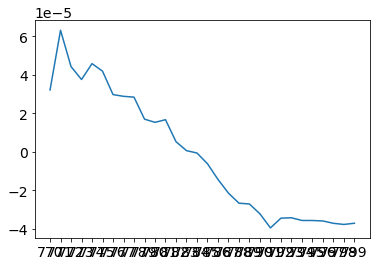

In [202]:
plt.plot(df_filtered.iloc[:,450:480].mean())

In [205]:
corrected_specs

[]

<AxesSubplot:>

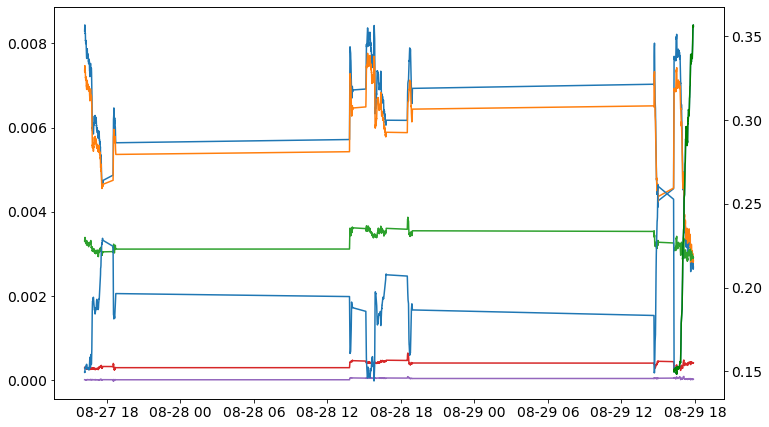

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(corrected_specs['420'].rolling(window=6*2).mean())
ax.plot(corrected_specs['440'].rolling(window=6*2).mean())

ax.plot(corrected_specs['520'].rolling(window=6*2).mean())


ax.plot(corrected_specs['660'].rolling(window=6*2).mean())
ax.plot(corrected_specs['750'].rolling(window=6*2).mean())

ax2 = ax.twinx()
ax2.plot(corrected_specs['chla_oci'].rolling(window=6*2).mean())
trios_df_transect['chla_oci'].rolling(window=6*2).mean().plot(ax=ax2, color='green')

# ax.set_ylim(0.002,0.01)
# trios_df_transect.plot('440')

In [209]:
trios_df_transect

320       321       322       323       324  \
2021-08-29 16:15:10  0.005234  0.005342  0.005383  0.005333  0.005271   
2021-08-29 16:15:20  0.005354  0.005442  0.005458  0.005385  0.005306   
2021-08-29 16:15:30  0.005755  0.005799  0.005783  0.005705  0.005626   
2021-08-29 16:15:40  0.005039  0.005119  0.005142  0.005082  0.005014   
2021-08-29 16:15:50  0.005586  0.005650  0.005663  0.005593  0.005512   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.002618  0.002661  0.002665  0.002617  0.002556   
2021-08-29 17:51:00  0.002667  0.002705  0.002704  0.002660  0.002607   
2021-08-29 17:51:30  0.001961  0.002004  0.002005  0.001965  0.001910   
2021-08-29 17:51:40  0.001919  0.001947  0.001940  0.001903  0.001852   
2021-08-29 17:52:00  0.003880  0.003927  0.003931  0.003873  0.003800   

                          325       326       327       328       329  ...  \
2021-08-29 16:15:10  0.005224  0.005256  0.005184  0.005047  0.005116  ...   
2021-08-29 16:15:20  0.005246  0.005269  0.005190  0.005048  0.005126  ...   
2021-08-29 16:15:30  0.005566  0.005592  0.005506  0.005350  0.005413  ...   
2021-08-29 16:15:40  0.004962  0.004985  0.004908  0.004768  0.004834  ...   
2021-08-29 16:15:50  0.005448  0.005473  0.005402  0.005266  0.005329  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.002509  0.002511  0.002439  0.002323  0.002358  ...   
2021-08-29 17:51:00  0.002566  0.002573  0.002503  0.002389  0.002424  ...   
2021-08-29 17:51:30  0.001868  0.001874  0.001801  0.001684  0.001718  ...   
2021-08-29 17:51:40  0.001812  0.001813  0.001745  0.001639  0.001675  ...   
2021-08-29 17:52:00  0.003741  0.003741  0.003657  0.003523  0.003552  ...   

                          948       949       950  chla_oci  \
2021-08-29 16:15:10 -0.000701 -0.000786 -0.000749  0.168734   
2021-08-29 16:15:20 -0.000644 -0.000569 -0.000461  0.150625   
2021-08-29 16:15:30 -0.000719 -0.000709 -0.000649  0.149730   
2021-08-29 16:15:40 -0.000623 -0.000551 -0.000451  0.145817   
2021-08-29 16:15:50 -0.000629 -0.000651 -0.000712  0.148233   
...                       ...       ...       ...       ...   
2021-08-29 17:50:50 -0.000325 -0.000320 -0.000317  0.354417   
2021-08-29 17:51:00 -0.000263 -0.000257 -0.000262  0.353535   
2021-08-29 17:51:30 -0.000011 -0.000038 -0.000071  0.358468   
2021-08-29 17:51:40  0.000035 -0.000018 -0.000100  0.361546   
2021-08-29 17:52:00 -0.000535 -0.000498 -0.000461  0.340929   

                              TimeStamp        lat        lon      sal  \
2021-08-29 16:15:10  8/29/2021 12:15:10  35.750405 -74.588497  35.5670   
2021-08-29 16:15:20  8/29/2021 12:15:20  35.750405 -74.588497  35.5670   
2021-08-29 16:15:30  8/29/2021 12:15:30  35.750405 -74.588497  35.5670   
2021-08-29 16:15:40  8/29/2021 12:15:40  35.750405 -74.588497  35.5670   
2021-08-29 16:15:50  8/29/2021 12:15:50  35.750458 -74.590245  35.5676   
...                                 ...        ...        ...      ...   
2021-08-29 17:50:50  8/29/2021 13:50:50  35.776593 -74.663812  32.2684   
2021-08-29 17:51:00  8/29/2021 13:51:00  35.776593 -74.663812  32.2684   
2021-08-29 17:51:30  8/29/2021 13:51:30  35.776593 -74.663812  32.2684   
2021-08-29 17:51:40  8/29/2021 13:51:40  35.776593 -74.663812  32.2684   
2021-08-29 17:52:00  8/29/2021 13:52:00  35.776885 -74.664582  32.2578   

                        temp                    geometry  
2021-08-29 16:15:10  28.7889  POINT (-74.58850 35.75041)  
2021-08-29 16:15:20  28.7889  POINT (-74.58850 35.75041)  
2021-08-29 16:15:30  28.7889  POINT (-74.58850 35.75041)  
2021-08-29 16:15:40  28.7889  POINT (-74.58850 35.75041)  
2021-08-29 16:15:50  28.7899  POINT (-74.59024 35.75046)  
...                      ...                         ...  
2021-08-29 17:50:50  28.3834  POINT (-74.66381 35.77659)  
2021-08-29 17:51:00  28.3834  POINT (-74.66381 35.77659)  
2021-08-29 17:51:30  28.3834  POINT

In [210]:
trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2]

320        NaN
321        NaN
322        NaN
323        NaN
324        NaN
            ..
949        NaN
950        NaN
chla_oci   NaN
lat        NaN
lon        NaN
Length: 634, dtype: float64

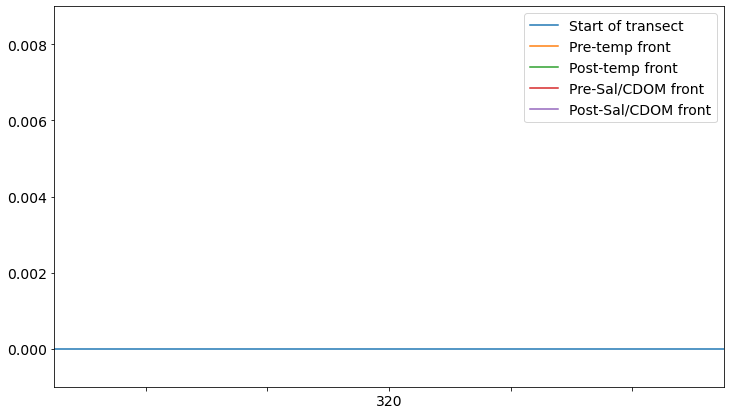

In [211]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)

ax.set_ylim(-0.001,0.009)

ax.legend()
# plt.savefig('radiometry_spectra.png')


In [ ]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)
ax.set_ylim(-0.001,0.009)

ax.legend()
# plt.savefig('radiometry_spectra.png')


In [ ]:
fig,ax = plt.subplots(figsize=(12,7))
corrected_specs.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

corrected_specs.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
corrected_specs.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
corrected_specs.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
corrected_specs.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)
ax.set_ylim(-0.001,0.009)


ax.legend()
# plt.savefig('radiometry_spectra.png')


In [ ]:
16:20-16:30, pelgic side of front, 16:53-16:56 at front, 17:15-17:20 coastal side of front before secondary front, 17:40-17:45 coastal side of both fronts

In [ ]:
corrected_specs.loc['2021-08-29 16:20:00':'2021-08-29 16:25:00'].median(numeric_only=True).iloc[:-5]

In [ ]:
corrected_specs.loc['2021-08-29 17:53:00':'2021-08-29 17:59:00']

In [ ]:
fig,ax = plt.subplots(figsize=(12,7))
corrected_specs.loc['2021-08-29 16:20:00':'2021-08-29 16:25:00'].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front')
corrected_specs.loc['2021-08-29 16:53:00':'2021-08-29 16:56:00'].median(numeric_only=True).iloc[:-5].plot(label='At front')
corrected_specs.loc['2021-08-29 17:15:00':'2021-08-29 17:20:00'].median(numeric_only=True).iloc[:-5].plot(label='Coastal side of front (at secondary)')
corrected_specs.loc['2021-08-29 17:40:00':'2021-08-29 17:45:00'].median(numeric_only=True).iloc[:-5].plot(label='Coastal side of both fronts')

# ax.axhline(0)
ax.set_xlim(100,550)
ax.set_ylim(-0.0001,0.008)
ax.set_xlabel('Wavelength(nm)')
ax.set_ylabel('Remote sensing reflectance')

ax.legend()
plt.savefig('figs/aug2916_radiometry_spectra.png')


In [213]:
corrected_specs[kmeans.labels_==0].iloc[:,:-7].values.T.mean(axis=1).shape

(630,)

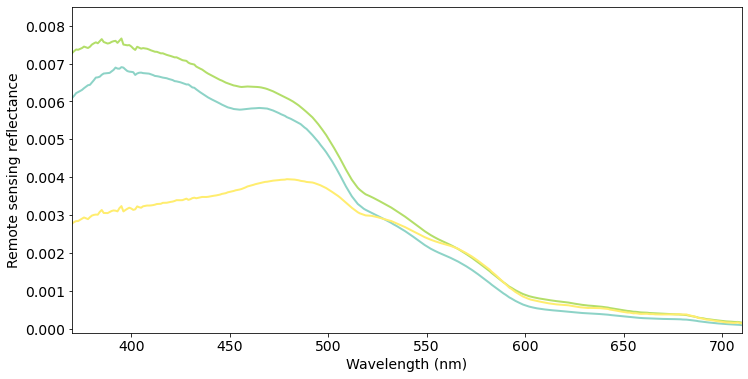

In [214]:
color_list = plt.cm.Set3(np.linspace(0, 1, 3))
color_list

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(370,710)
ax.set_ylim(-0.0001,0.0085)
# ax.axvline(120, c='k', ls='--')
# ax.axvline(535-125, c='k', ls='--')
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T,c=color_list[1], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T,c=color_list[0], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T,c=color_list[2], alpha=.01)

ax.plot(corrected_specs.columns[:-7].astype(int), corrected_specs[kmeans.labels_==0].iloc[:,:-7].values.T.mean(axis=1),c=color_list[1], alpha=1, lw=2)
ax.plot(corrected_specs.columns[:-7].astype(int), corrected_specs[kmeans.labels_==1].iloc[:,:-7].values.T.mean(axis=1),c=color_list[0], alpha=1, lw=2)
ax.plot(corrected_specs.columns[:-7].astype(int), corrected_specs[kmeans.labels_==2].iloc[:,:-7].values.T.mean(axis=1),c=color_list[2], alpha=1, lw=2)

# trios_subset[kmeans.labels_==0].iloc[:,:-8].plot(label='Pelagic side of front', ax=ax, c=color_list[1], lw=3)
# trios_subset[kmeans.labels_==1].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[0], lw=3)
# trios_subset[kmeans.labels_==2].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[2], lw=3)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Remote sensing reflectance')

# fig.savefig('figs/aug2916_trios_clusters_spectra.png',dpi=300)

Text(0, 0.5, 'Remote sensing reflectance')

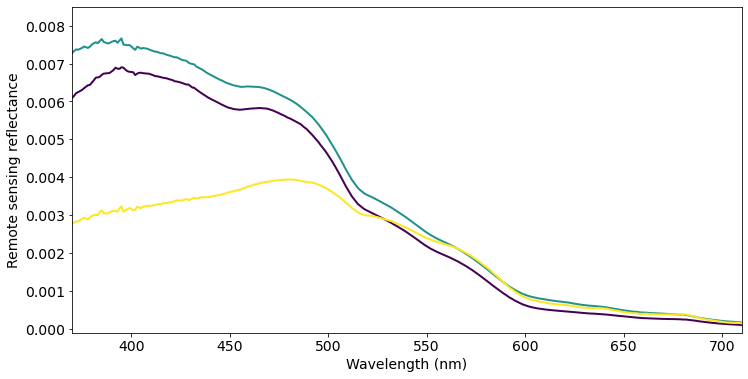

In [249]:
color_list = plt.cm.viridis(np.linspace(0, 1, 3))
color_list

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(370,710)
ax.set_ylim(-0.0001,0.0085)
# ax.axvline(120, c='k', ls='--')
# ax.axvline(535-125, c='k', ls='--')
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T,c=color_list[1], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T,c=color_list[0], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T,c=color_list[2], alpha=.01)

ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==0].iloc[:,:-8].values.T.mean(axis=1),c=color_list[1], alpha=1, lw=2)
ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==1].iloc[:,:-8].values.T.mean(axis=1),c=color_list[0], alpha=1, lw=2)
ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==2].iloc[:,:-8].values.T.mean(axis=1),c=color_list[2], alpha=1, lw=2)

# trios_subset[kmeans.labels_==0].iloc[:,:-8].plot(label='Pelagic side of front', ax=ax, c=color_list[1], lw=3)
# trios_subset[kmeans.labels_==1].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[0], lw=3)
# trios_subset[kmeans.labels_==2].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[2], lw=3)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Remote sensing reflectance')

# fig.savefig('figs/aug2916_trios_clusters_spectra.png',dpi=300)

Text(0, 0.5, 'Remote sensing reflectance')

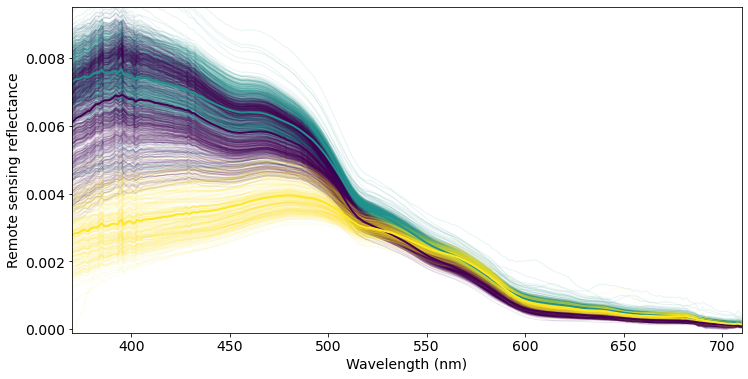

In [261]:
color_list = plt.cm.viridis(np.linspace(0, 1, 3))
color_list

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(370,710)
ax.set_ylim(-0.0001,0.0095)
# ax.axvline(120, c='k', ls='--')
# ax.axvline(535-125, c='k', ls='--')
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T,c=color_list[1], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T,c=color_list[0], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T,c=color_list[2], alpha=.01)

ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==0].iloc[:,:-8].values.T,c=color_list[1], alpha=.1, lw=1)
ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==1].iloc[:,:-8].values.T,c=color_list[0], alpha=.1, lw=1)
ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==2].iloc[:,:-8].values.T,c=color_list[2], alpha=.1, lw=1)

ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==0].iloc[:,:-8].values.T.mean(axis=1),c=color_list[1], alpha=1, lw=2)
ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==1].iloc[:,:-8].values.T.mean(axis=1),c=color_list[0], alpha=1, lw=2)
ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==2].iloc[:,:-8].values.T.mean(axis=1),c=color_list[2], alpha=1, lw=2)

# trios_subset[kmeans.labels_==0].iloc[:,:-8].plot(label='Pelagic side of front', ax=ax, c=color_list[1], lw=3)
# trios_subset[kmeans.labels_==1].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[0], lw=3)
# trios_subset[kmeans.labels_==2].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[2], lw=3)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Remote sensing reflectance')

# fig.savefig('figs/aug2916_trios_clusters_spectra.png',dpi=300)

Text(0, 0.5, 'Remote sensing reflectance')

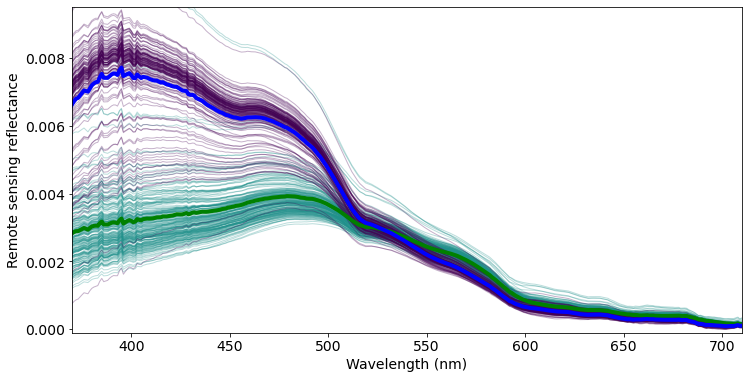

In [312]:
color_list = plt.cm.viridis(np.linspace(0, 1, 3))
color_list

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(370,710)
ax.set_ylim(-0.0001,0.0095)
# ax.axvline(120, c='k', ls='--')
# ax.axvline(535-125, c='k', ls='--')
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T,c=color_list[1], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T,c=color_list[0], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T,c=color_list[2], alpha=.01)

ax.plot(corrected_subset.columns[:-8].astype(int), corrected_subset[kmeans.labels_==0].iloc[:,:-8].values.T,c=color_list[1], alpha=.3, lw=1)
ax.plot(corrected_subset.columns[:-8].astype(int), corrected_subset[kmeans.labels_==1].iloc[:,:-8].values.T,c=color_list[0], alpha=.3, lw=1)
# ax.plot(corrected_subset.columns[:-8].astype(int), corrected_subset[kmeans.labels_==2].iloc[:,:-8].values.T,c=color_list[2], alpha=.1, lw=1)

ax.plot(corrected_subset.columns[:-8].astype(int), corrected_subset[kmeans.labels_==0].iloc[:,:-8].values.T.mean(axis=1),c='green', alpha=1, lw=4)
ax.plot(corrected_subset.columns[:-8].astype(int), corrected_subset[kmeans.labels_==1].iloc[:,:-8].values.T.mean(axis=1),c='blue', alpha=1, lw=4)
# ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==2].iloc[:,:-8].values.T.mean(axis=1),c=color_list[2], alpha=1, lw=2)

# trios_subset[kmeans.labels_==0].iloc[:,:-8].plot(label='Pelagic side of front', ax=ax, c=color_list[1], lw=3)
# trios_subset[kmeans.labels_==1].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[0], lw=3)
# trios_subset[kmeans.labels_==2].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[2], lw=3)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Remote sensing reflectance')

# fig.savefig('figs/aug2916_trios_clusters_spectra.png',dpi=300)

In [315]:
corrected_subset.TimeStamp

2021-08-29 16:15:10    8/29/2021 12:15:10
2021-08-29 16:15:20    8/29/2021 12:15:20
2021-08-29 16:15:30    8/29/2021 12:15:30
2021-08-29 16:15:40    8/29/2021 12:15:40
2021-08-29 16:15:50    8/29/2021 12:15:50
                              ...        
2021-08-29 17:50:50    8/29/2021 13:50:50
2021-08-29 17:51:00    8/29/2021 13:51:00
2021-08-29 17:51:30    8/29/2021 13:51:30
2021-08-29 17:51:40    8/29/2021 13:51:40
2021-08-29 17:52:00    8/29/2021 13:52:00
Name: TimeStamp, Length: 344, dtype: object

In [316]:
corrected_subset.TimeStamp

2021-08-29 16:15:10    8/29/2021 12:15:10
2021-08-29 16:15:20    8/29/2021 12:15:20
2021-08-29 16:15:30    8/29/2021 12:15:30
2021-08-29 16:15:40    8/29/2021 12:15:40
2021-08-29 16:15:50    8/29/2021 12:15:50
                              ...        
2021-08-29 17:50:50    8/29/2021 13:50:50
2021-08-29 17:51:00    8/29/2021 13:51:00
2021-08-29 17:51:30    8/29/2021 13:51:30
2021-08-29 17:51:40    8/29/2021 13:51:40
2021-08-29 17:52:00    8/29/2021 13:52:00
Name: TimeStamp, Length: 344, dtype: object

In [323]:
color_list.shape

(344, 4)

Text(0, 0.5, 'Remote sensing reflectance')

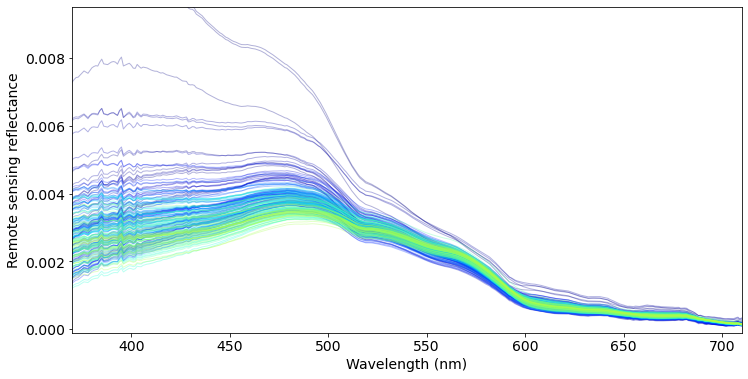

In [327]:
color_list = plt.cm.jet(np.linspace(0, 1, 344))
color_list

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(370,710)
ax.set_ylim(-0.0001,0.0095)
# ax.axvline(120, c='k', ls='--')
# ax.axvline(535-125, c='k', ls='--')
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T,c=color_list[1], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T,c=color_list[0], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T,c=color_list[2], alpha=.01)

for i in range(len(corrected_subset[kmeans.labels_==0].iloc[:,:-8].values)):
    ax.plot(corrected_subset.columns[:-8].astype(int), corrected_subset[kmeans.labels_==0].iloc[i,:-8].values.T, c=color_list[i], alpha=.3, lw=1)
# ax.plot(corrected_subset.columns[:-8].astype(int), corrected_subset[kmeans.labels_==1].iloc[:,:-8].values.T,c=color_list[0], alpha=.3, lw=1)
# ax.plot(corrected_subset.columns[:-8].astype(int), corrected_subset[kmeans.labels_==2].iloc[:,:-8].values.T,c=color_list[2], alpha=.1, lw=1)
# ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==2].iloc[:,:-8].values.T.mean(axis=1),c=color_list[2], alpha=1, lw=2)

# trios_subset[kmeans.labels_==0].iloc[:,:-8].plot(label='Pelagic side of front', ax=ax, c=color_list[1], lw=3)
# trios_subset[kmeans.labels_==1].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[0], lw=3)
# trios_subset[kmeans.labels_==2].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[2], lw=3)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Remote sensing reflectance')

# fig.savefig('figs/aug2916_trios_clusters_spectra.png',dpi=300)

(400.0, 550.0)

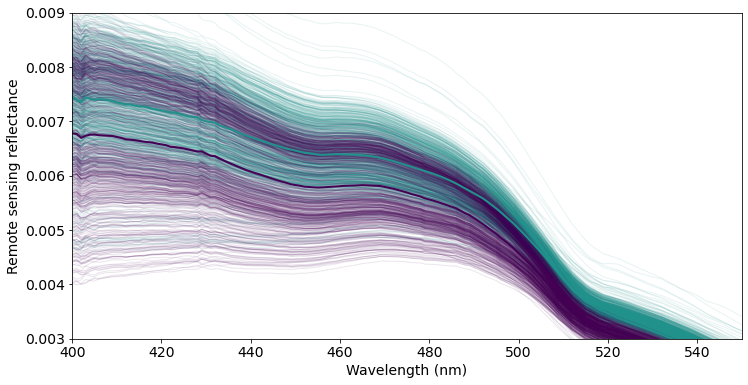

In [264]:
color_list = plt.cm.viridis(np.linspace(0, 1, 3))
color_list

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(370,710)
ax.set_ylim(-0.0001,0.0095)
# ax.axvline(120, c='k', ls='--')
# ax.axvline(535-125, c='k', ls='--')
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T,c=color_list[1], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T,c=color_list[0], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T,c=color_list[2], alpha=.01)

ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==0].iloc[:,:-8].values.T,c=color_list[1], alpha=.1, lw=1)
ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==1].iloc[:,:-8].values.T,c=color_list[0], alpha=.1, lw=1)
# ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==2].iloc[:,:-8].values.T,c=color_list[2], alpha=.1, lw=1)

ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==0].iloc[:,:-8].values.T.mean(axis=1),c=color_list[1], alpha=1, lw=2)
ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==1].iloc[:,:-8].values.T.mean(axis=1),c=color_list[0], alpha=1, lw=2)
# ax.plot(corrected_specs.columns[:-8].astype(int), corrected_specs[kmeans.labels_==2].iloc[:,:-8].values.T.mean(axis=1),c=color_list[2], alpha=1, lw=2)

# trios_subset[kmeans.labels_==0].iloc[:,:-8].plot(label='Pelagic side of front', ax=ax, c=color_list[1], lw=3)
# trios_subset[kmeans.labels_==1].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[0], lw=3)
# trios_subset[kmeans.labels_==2].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[2], lw=3)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Remote sensing reflectance')

ax.set_ylim(0.003,0.009)
ax.set_xlim(400,550)

# fig.savefig('figs/aug2916_trios_clusters_spectra.png',dpi=300)

In [219]:
corrected_specs['cluster'] = kmeans.labels_

In [220]:
corrected_specs.to_csv('trios_clusters_spectra_160922.csv')

# Run some clustering

In [266]:
len(start_times)

13

In [267]:
corrected_subset = corrected_specs.loc[start_times[-1]:end_times[-1]]

In [270]:
corrected_subset

321       322       323       324       325  \
2021-08-29 16:15:10  0.005342  0.005383  0.005333  0.005271  0.005224   
2021-08-29 16:15:20  0.005442  0.005458  0.005385  0.005306  0.005246   
2021-08-29 16:15:30  0.005799  0.005783  0.005705  0.005626  0.005566   
2021-08-29 16:15:40  0.005119  0.005142  0.005082  0.005014  0.004962   
2021-08-29 16:15:50  0.005650  0.005663  0.005593  0.005512  0.005448   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.002661  0.002665  0.002617  0.002556  0.002509   
2021-08-29 17:51:00  0.002705  0.002704  0.002660  0.002607  0.002566   
2021-08-29 17:51:30  0.002004  0.002005  0.001965  0.001910  0.001868   
2021-08-29 17:51:40  0.001947  0.001940  0.001903  0.001852  0.001812   
2021-08-29 17:52:00  0.003927  0.003931  0.003873  0.003800  0.003741   

                          326       327       328       329       330  ...  \
2021-08-29 16:15:10  0.005256  0.005184  0.005047  0.005116  0.005195  ...   
2021-08-29 16:15:20  0.005269  0.005190  0.005048  0.005126  0.005227  ...   
2021-08-29 16:15:30  0.005592  0.005506  0.005350  0.005413  0.005506  ...   
2021-08-29 16:15:40  0.004985  0.004908  0.004768  0.004834  0.004930  ...   
2021-08-29 16:15:50  0.005473  0.005402  0.005266  0.005329  0.005418  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.002511  0.002439  0.002323  0.002358  0.002402  ...   
2021-08-29 17:51:00  0.002573  0.002503  0.002389  0.002424  0.002466  ...   
2021-08-29 17:51:30  0.001874  0.001801  0.001684  0.001718  0.001763  ...   
2021-08-29 17:51:40  0.001813  0.001745  0.001639  0.001675  0.001718  ...   
2021-08-29 17:52:00  0.003741  0.003657  0.003523  0.003552  0.003590  ...   

                          949       950  chla_oci           TimeStamp  \
2021-08-29 16:15:10 -0.000786 -0.000749  0.168597  8/29/2021 12:15:10   
2021-08-29 16:15:20 -0.000569 -0.000461  0.150440  8/29/2021 12:15:20   
2021-08-29 16:15:30 -0.000709 -0.000649  0.149546  8/29/2021 12:15:30   
2021-08-29 16:15:40 -0.000551 -0.000451  0.145591  8/29/2021 12:15:40   
2021-08-29 16:15:50 -0.000651 -0.000712  0.148038  8/29/2021 12:15:50   
...                       ...       ...       ...                 ...   
2021-08-29 17:50:50 -0.000320 -0.000317  0.351876  8/29/2021 13:50:50   
2021-08-29 17:51:00 -0.000257 -0.000262  0.350977  8/29/2021 13:51:00   
2021-08-29 17:51:30 -0.000038 -0.000071  0.355763  8/29/2021 13:51:30   
2021-08-29 17:51:40 -0.000018 -0.000100  0.358837  8/29/2021 13:51:40   
2021-08-29 17:52:00 -0.000498 -0.000461  0.338601  8/29/2021 13:52:00   

                           lat        lon      sal     temp  \
2021-08-29 16:15:10  35.750405 -74.588497  35.5670  28.7889   
2021-08-29 16:15:20  35.750405 -74.588497  35.5670  28.7889   
2021-08-29 16:15:30  35.750405 -74.588497  35.5670  28.7889   
2021-08-29 16:15:40  35.750405 -74.588497  35.5670  28.7889   
2021-08-29 16:15:50  35.750458 -74.590245  35.5676  28.7899   
...                        ...        ...      ...      ...   
2021-08-29 17:50:50  35.776593 -74.663812  32.2684  28.3834   
2021-08-29 17:51:00  35.776593 -74.663812  32.2684  28.3834   
2021-08-29 17:51:30  35.776593 -74.663812  32.2684  28.3834   
2021-08-29 17:51:40  35.776593 -74.663812  32.2684  28.3834   
2021-08-29 17:52:00  35.776885 -74.664582  32.2578  28.3997   

                                       geometry  cluster  
2021-08-29 16:15:10  POINT (-74.58850 35.75041)        1  
2021-08-29 16:15:20  POINT (-74.58850 35.75041)        1  
2021-08-29 16:15:30  POINT (-74.58850 35.75041)        1  
2021-08-29 16:15:40  POINT (-74.58850 35.75041)        1  
2021-08-29 16:15:50  POINT (-74.59024 35.75046)        1  
...                                         ...      ...  
2021-08-29 17:50:50  POINT (-74.66381 35.77659)        2  
2021-08-29 17:51:00  POINT (-74.66381 35.77659)        2  
2021-08-29 17:51:30  POINT (-74.66381 35.77659)

In [275]:
corrected_subset.iloc[:,:-7]

321       322       323       324       325  \
2021-08-29 16:15:10  0.005342  0.005383  0.005333  0.005271  0.005224   
2021-08-29 16:15:20  0.005442  0.005458  0.005385  0.005306  0.005246   
2021-08-29 16:15:30  0.005799  0.005783  0.005705  0.005626  0.005566   
2021-08-29 16:15:40  0.005119  0.005142  0.005082  0.005014  0.004962   
2021-08-29 16:15:50  0.005650  0.005663  0.005593  0.005512  0.005448   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.002661  0.002665  0.002617  0.002556  0.002509   
2021-08-29 17:51:00  0.002705  0.002704  0.002660  0.002607  0.002566   
2021-08-29 17:51:30  0.002004  0.002005  0.001965  0.001910  0.001868   
2021-08-29 17:51:40  0.001947  0.001940  0.001903  0.001852  0.001812   
2021-08-29 17:52:00  0.003927  0.003931  0.003873  0.003800  0.003741   

                          326       327       328       329       330  ...  \
2021-08-29 16:15:10  0.005256  0.005184  0.005047  0.005116  0.005195  ...   
2021-08-29 16:15:20  0.005269  0.005190  0.005048  0.005126  0.005227  ...   
2021-08-29 16:15:30  0.005592  0.005506  0.005350  0.005413  0.005506  ...   
2021-08-29 16:15:40  0.004985  0.004908  0.004768  0.004834  0.004930  ...   
2021-08-29 16:15:50  0.005473  0.005402  0.005266  0.005329  0.005418  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.002511  0.002439  0.002323  0.002358  0.002402  ...   
2021-08-29 17:51:00  0.002573  0.002503  0.002389  0.002424  0.002466  ...   
2021-08-29 17:51:30  0.001874  0.001801  0.001684  0.001718  0.001763  ...   
2021-08-29 17:51:40  0.001813  0.001745  0.001639  0.001675  0.001718  ...   
2021-08-29 17:52:00  0.003741  0.003657  0.003523  0.003552  0.003590  ...   

                          942       943       944       945       946  \
2021-08-29 16:15:10 -0.000468 -0.000381 -0.000260 -0.000141 -0.000235   
2021-08-29 16:15:20 -0.000600 -0.000486 -0.000381 -0.000276 -0.000403   
2021-08-29 16:15:30 -0.000585 -0.000709 -0.000770 -0.000830 -0.000726   
2021-08-29 16:15:40 -0.000581 -0.000557 -0.000587 -0.000618 -0.000626   
2021-08-29 16:15:50 -0.001083 -0.000967 -0.000850 -0.000734 -0.000690   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50 -0.000253 -0.000283 -0.000298 -0.000314 -0.000306   
2021-08-29 17:51:00 -0.000342 -0.000362 -0.000335 -0.000305 -0.000286   
2021-08-29 17:51:30 -0.000184 -0.000176 -0.000126 -0.000076 -0.000028   
2021-08-29 17:51:40 -0.000139 -0.000095 -0.000079 -0.000066 -0.000023   
2021-08-29 17:52:00 -0.000416 -0.000482 -0.000547 -0.000610 -0.000582   

                          947       948       949       950  chla_oci  
2021-08-29 16:15:10 -0.000450 -0.000701 -0.000786 -0.000749  0.168597  
2021-08-29 16:15:20 -0.000530 -0.000644 -0.000569 -0.000461  0.150440  
2021-08-29 16:15:30 -0.000702 -0.000719 -0.000709 -0.000649  0.149546  
2021-08-29 16:15:40 -0.000626 -0.000623 -0.000551 -0.000451  0.145591  
2021-08-29 16:15:50 -0.000659 -0.000629 -0.000651 -0.000712  0.148038  
...                       ...       ...       ...       ...       ...  
2021-08-29 17:50:50 -0.000312 -0.000325 -0.000320 -0.000317  0.351876  
2021-08-29 17:51:00 -0.000274 -0.000263 -0.000257 -0.000262  0.350977  
2021-08-29 17:51:30 -0.000013 -0.000011 -0.000038 -0.000071  0.355763  
2021-08-29 17:51:40  0.000010  0.000035 -0.000018 -0.000100  0.358837  
2021-08-29 17:52:00 -0.000555 -0.000535 -0.000498 -0.000461  0.338601  

[344 rows x 631 columns]

In [277]:
X = corrected_subset.iloc[:,:-8].values

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

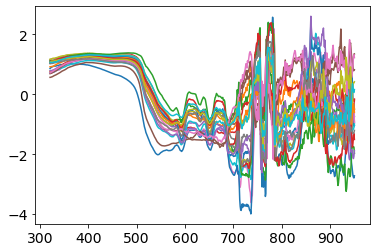

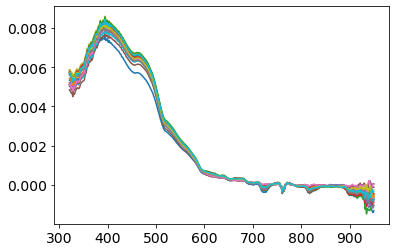

In [279]:
plt.plot([int(i) for i in corrected_subset.iloc[:,:-8].columns], X_scaled[0:20].T)
plt.show()

plt.plot([int(i) for i in corrected_subset.iloc[:,:-8].columns], X[0:20].T)
plt.show()

#### I'm cropping these a bit to cut off the ultraviolet and the NIR that is basically 0 but becomes noisy when standardized

In [282]:
X = corrected_subset.iloc[:,80:-278].values

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

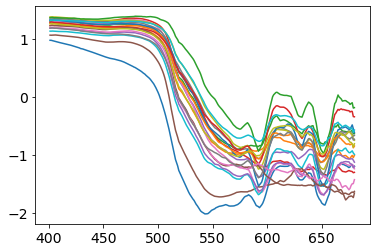

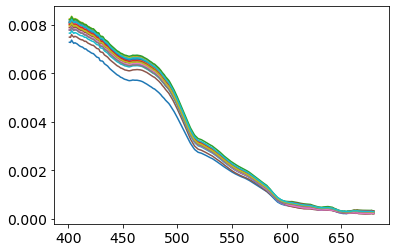

In [283]:
plt.plot([int(i) for i in corrected_subset.iloc[:,80:-278].columns], X_scaled[0:20].T)
plt.show()

plt.plot([int(i) for i in corrected_subset.iloc[:,80:-278].columns], X[0:20].T)
plt.show()

In [284]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_scaled)
    Sum_of_squared_distances.append(km.inertia_)

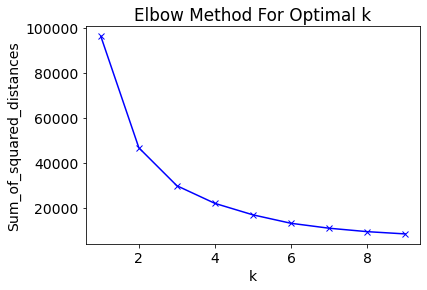

In [285]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [286]:
# from kneed import KneeLocator
# kl = KneeLocator(
#     range(1, 11), sse, curve="convex", direction="decreasing"
# )

# kl.elbow

In [287]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

In [288]:
from sklearn.metrics import silhouette_score
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

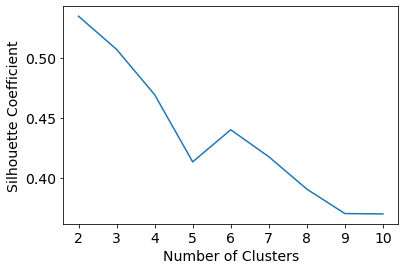

In [289]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

These are both clear that there are 3 clusters

In [290]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_scaled)

In [291]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([199, 145]))

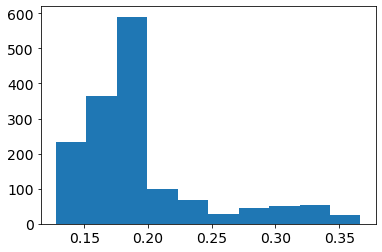

In [292]:
plt.hist(corrected_specs.chla_oci)
plt.show()

In [179]:
trios_gdf_transect = trios_gdf#.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']

In [180]:
x = trios_gdf_transect.rolling(window=6).mean().values[:,1:-7]

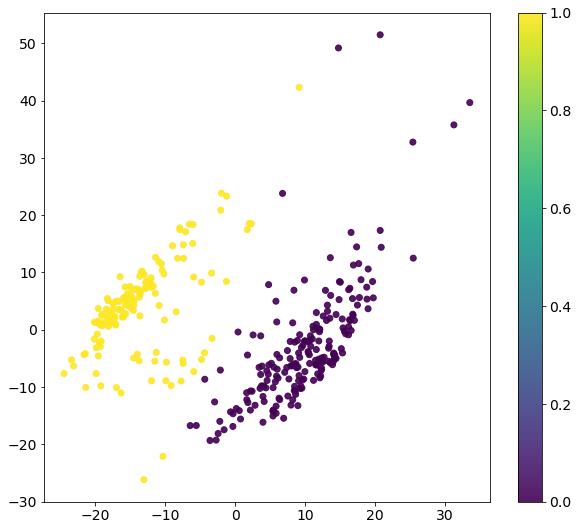

In [293]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_, cmap='viridis', label='chla')
fig.colorbar(sc)

In [185]:
principalComponents.shape

(1556, 2)

<AxesSubplot:>

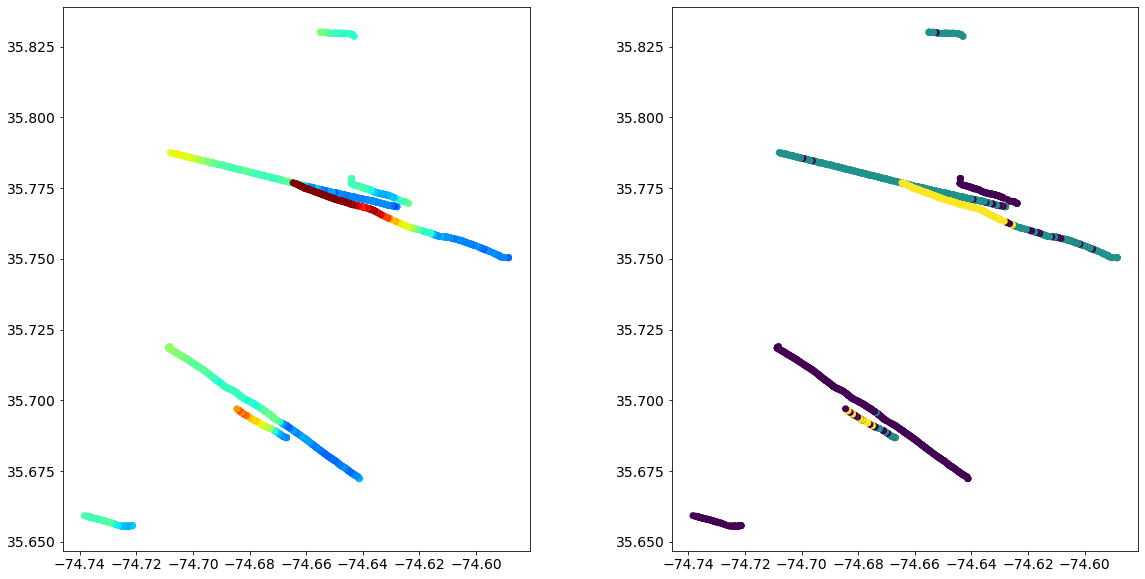

In [255]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
# ax.plot(trios_gdf_transect.iloc[12:].lon,trios_gdf_transect.iloc[12:].lat,c=trios_gdf_transect.iloc[12:].chla_oci.values)

trios_gdf.plot(column='chla_oci', cmap='jet', vmin=0.1,vmax=0.3, legend=False,ax=ax[0])

trios_gdf.plot(c=kmeans.labels_,ax=ax[1])
# fig.savefig('chla_transect.png')

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['sal'].iloc[12:], trios_gdf_transect['temp'].iloc[12:], alpha=0.3, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.13,vmax=.25, cmap='viridis', label='chla')

ax.set_xlabel("Salinity")
ax.set_ylabel("Temperature")


fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

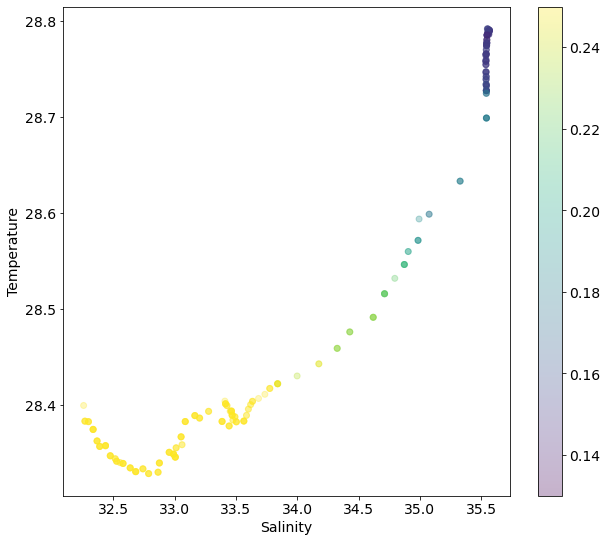

In [294]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(corrected_subset['sal'], corrected_subset['temp'], alpha=0.3, c=corrected_subset['chla_oci'], vmin=.13,vmax=.25, cmap='viridis', label='chla')

ax.set_xlabel("Salinity")
ax.set_ylabel("Temperature")


fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

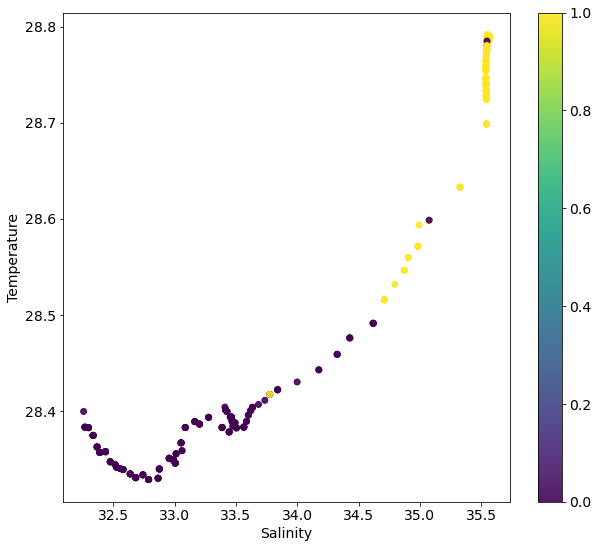

In [301]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(corrected_subset['sal'], corrected_subset['temp'], alpha=0.9, c=kmeans.labels_, cmap='viridis', label='chla')

ax.set_xlabel("Salinity")
ax.set_ylabel("Temperature")


fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

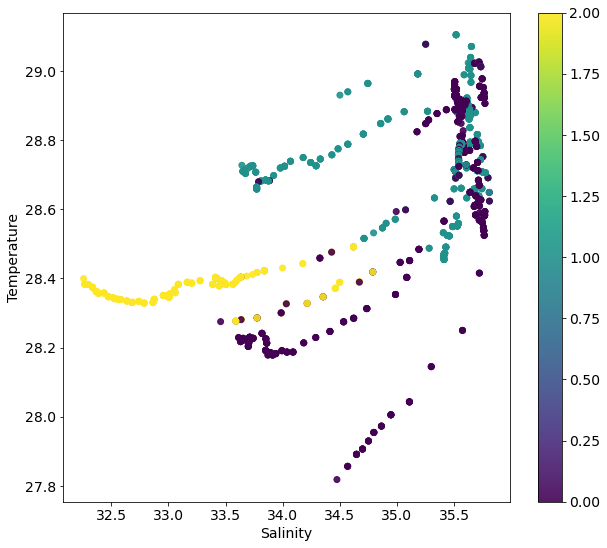

In [258]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['sal'].iloc[12:], trios_gdf_transect['temp'].iloc[12:], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')

ax.set_xlabel("Salinity")
ax.set_ylabel("Temperature")


fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_[12:], cmap='Set1', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [ ]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=5, random_state=0).fit(x)
# np.unique(kmeans.labels_, return_counts=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['lon'].iloc[12:], trios_gdf_transect['lat'].iloc[12:], alpha=0.9, c=kmeans.labels_[12:], cmap='Set1', label='chla')

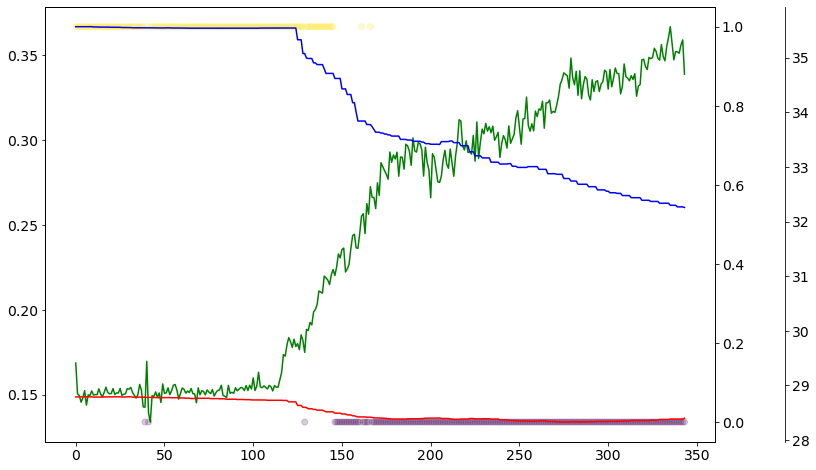

In [300]:
fig, ax  =plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,len(x)),corrected_subset.chla_oci, c='green')

ax2=ax.twinx()
ax2.scatter(np.arange(0,len(x)), kmeans.labels_, alpha=0.2, c=kmeans.labels_)

ax3 = ax.twinx()
ax3.plot(np.arange(0,len(x)),corrected_subset['sal'], color='blue')
ax3.plot(np.arange(0,len(x)),corrected_subset['temp'], color='red')
ax3.spines['right'].set_position(('outward', 70))

# fig.savefig('cluster_chla.png')

ValueError: x and y must have same first dimension, but have shapes (344,) and (1544,)

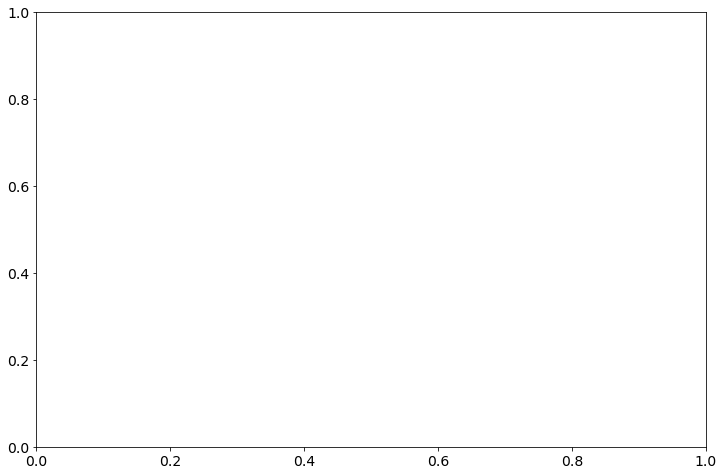